
# Выпускной проект курса "Анализ данных" (da93_ecom)

Материалы:

[Презентация](https://disk.yandex.ru/i/2uHwHeEYJWG9vQ)<br>
[Интерактивный дашборд Tableau](https://public.tableau.com/shared/G5QHYCDTC?:display_count=n&:origin=viz_share_link)


# Анализ товарного ассортимента интернет-магазина товаров для дома

На основе данных транзакций **интернет-магазина товаров для дома и быта «Пока все ещё тут»**, нам предстоит углубиться в анализ товарного предложения и продаж для составления рекомендаций по ассортиментной политике для менеджеров по товарному ассортименту.

По результатам проведенного анализа мы сможем сегментировать ассортимент по уровню значимости для продаж, провести его категоризацию и дать рекомендации по каждой из категорий, составить картину временной динамики продаж ассортимента и дать рекомендации для отделов товарного ассортимента и маркетинга для максимизации продаж.

Результаты исследования представлены в виде презентации и интерактивного дашборда Tableau.

# Декомпозиция задачи


## Загрузка и первичная обработка данных

### Импорт необходимых библиотек, прочие настройки

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from datetime import timedelta
from nltk.corpus import stopwords       # для обработки текста
import nltk                             # для обработтки текста
import requests                         # для парсинга веб страниц
from bs4 import BeautifulSoup           # для парсинга веб страниц


In [2]:
# Установить максимальное количество столбцов для отображения
pd.set_option('display.max_columns', None)

# Разрешить вывод DataFrame на всю ширину экрана
pd.set_option('display.expand_frame_repr', False)

# Установить максимальную ширину столбца для отображения
pd.set_option('display.max_colwidth', None)

# вывод разделителя для ттекста
def line():
    print('----------------------------------------------------------------')

# Загрузка стоп-слов для русского языка
nltk.download('stopwords')
russian_stopwords = set(stopwords.words('russian'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bobri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Загрузка данных, вывод общей информации 

In [3]:
url = 'https://code.s3.yandex.net/datasets/ecom_dataset_upd.csv'

try:
    df = pd.read_csv(url)
    print("Данные успешно загружены")
except pd.errors.EmptyDataError:
    print("Ошибка: файл пуст")
except pd.errors.ParserError:
    print("Ошибка: проблема с парсингом файла")
except FileNotFoundError:
    print("Ошибка: файл не найден")
except Exception as e:
    print(f"Произошла ошибка: {e}")

# Проверка загруженных данных
display(df.head())

Данные успешно загружены


,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


7474 записи


`date` - колонка с датой заказа<br>
`сustomer_id` - идентификатор пользователя<br>
`order_id` - номер заказа<br>
`product` - название продукта<br>
`quantity` - количество в заказе<br>
`price` - цена<br>


### Проверка на пропущенные значения, полные и неявные дубликаты

In [4]:
# Основная информация
print(df.info())
line()

# Проверка на наличие полных дубликатов
print('Полных дубликаов - ', df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7474 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         7474 non-null   int64  
 1   customer_id  7474 non-null   object 
 2   order_id     7474 non-null   int64  
 3   product      7474 non-null   object 
 4   quantity     7474 non-null   int64  
 5   price        7474 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 350.5+ KB
None
----------------------------------------------------------------
Полных дубликаов -  0


- в базе 7474 записи, пропусков нет ни в одной из колонок, полных дубликатов нет. Проверим на наличие дубликатов по колонкам `customer_id`,`order_id`,`product`,`quantity`,`price` - у одного клиента в заказе может быть товар с разными ценами, поэтому оставляем для проверки id клиента, номер заказа, продукт и цену.

In [5]:
print(
    'Количество неполных дубликатов',
    df.duplicated( ['customer_id','order_id','product','price']).sum()
    )

Количество неполных дубликатов 1884


- Дубликатов 25% от общего количества записей! Это очень много, надо поговорить с коллегами, которые занимаются формированием базы данных продаж - возможно, естть какие-то технические неполадки и ошибки, ведущие к задвоению записей. Выведем часть из них

In [6]:
display(df[df.duplicated(['customer_id','order_id','product','price'])])

,date,customer_id,order_id,product,quantity,price
58,2018100218,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 см металлическая сетка 35748W,1,3299.0
59,2018100219,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 см металлическая сетка 35748W,1,3299.0
60,2018100220,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 см металлическая сетка 35748W,1,3299.0
63,2018100304,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 см металлическая сетка 35748W,1,3299.0
94,2018100413,32de7df8-8d4f-4c84-a7b9-c41d00dd83ba,68522,Эвкалипт Гунни d-17 см h-60 см,1,1409.0
...,...,...,...,...,...,...
6706,2019102810,57cc80a2-2610-4eef-9457-e7c3bf0c72f0,70960,Сумка-тележка 2-х колесная Gimi Argo красная,1,1087.0
6711,2019102821,cb65d08a-dae7-4890-aef0-bb9f79055e02,73108,Мирт d-9 см h-15 см,1,134.0
6728,2019103100,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,73136,"Таз пластмассовый со стиральной доской (Иж), 1404021",1,397.0
6729,2019103102,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,73136,"Таз пластмассовый со стиральной доской (Иж), 1404021",1,397.0


- мы видим, что записи повторяюся с одинаковым клиентом, заказом, продуктом, количеством и ценой, но с разными датами. Коллеги в техническом отделе подтвердили, что это ошибка и можно оставить только 1 из дублирующихся записей. Проведем удаление и проверим результат.

In [7]:
# Удаление дубликатов по указанным столбцам
df.drop_duplicates(subset=['customer_id', 'order_id', 'product', 'price'], keep='last', inplace=True, ignore_index=True)

display(df.head())
line()

print(
    'Количество неполных дубликатов',
    df.duplicated( ['customer_id','order_id','product','price']).sum()
    )

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


----------------------------------------------------------------
Количество неполных дубликатов 0


- дубликаты удалены, в базе осталось 5590 записей.

### Проверка корректности названий и типов данных полей

- дата сохранена в виде теста в формате `год-месяц-день-час`, преобразуем ее в формат даты

In [8]:
# Преобразование столбца date в формат datetime
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d%H')
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5590 entries, 0 to 5589
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         5590 non-null   datetime64[ns]
 1   customer_id  5590 non-null   object        
 2   order_id     5590 non-null   int64         
 3   product      5590 non-null   object        
 4   quantity     5590 non-null   int64         
 5   price        5590 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 262.2+ KB
None


- остальные типы данных подобраны верно - целочисленный для номера заказа и для количества в заказе, с плавающей точкой для цены, строка для id клиента и продукта. Можем для оптимизации использования памяти скорректировать тип int64 на int16, количество в заказе врядли превысит 32767б,  но на нашей небольшой базе особого выигрыша не будет.

### Загрузка и первичная обработка данных: выводы

Данные были успешно загружены - 7474 записи, пропусков и полных дублиаов не обнаружено. Однако мы выявили **1884 частичных дубликата записей**: - одинаковые продукты в одном заказе с одинковой ценой. Информация об ошибочных записяк донесена до коллег, принято решение об удалении дубликатов. Следует обратить внимание на источних эттих ошибок.

Также поменяли тип данных даты с текстового на `datetime`. Остальные данные и названия колонок в порядке. 

## Исследовательский анализ данных 

### Анализ данных в полях: распределение, выбросы, формат, количество уникальных значений

In [9]:
# Статистическое резюме
print(df.describe())

                                date       order_id     quantity         price
count                           5590    5590.000000  5590.000000   5590.000000
mean   2019-05-05 10:57:35.098390016   56049.137925     2.605725    531.148673
min              2018-10-01 00:00:00   12624.000000     1.000000      9.000000
25%              2019-01-30 10:30:00   14814.000000     1.000000     90.000000
50%              2019-04-29 11:00:00   69229.500000     1.000000    150.000000
75%              2019-07-29 05:15:00   71933.750000     1.000000    524.000000
max              2020-01-31 15:00:00  112789.000000  1000.000000  14917.000000
std                              NaN   32370.217263    16.445386    973.084687


- в нашем распоряжении **5590 записей**
- первый заказ сделан **2018-10-01** 00:00:00, последний **2020-01-31** 15:00:00
- нумерация заказов идет с **12624 по 112789**, следовательно, не последовательно (x, x+1, x+2....n)
- минимальное количество товара в строке заказа - 1. Максимальное - **1000 шт**. Судя по тому, что медиана и 75% персентиль равны 1, **есть значительные выбросы в значениях количеств**
- самый дешевый товар стоит **9 рублей**, самый дорогой - **14917 рублей**. Медиана 150 рублей, 75% персентиль 574 рубля

Посмотрим на распределение графически


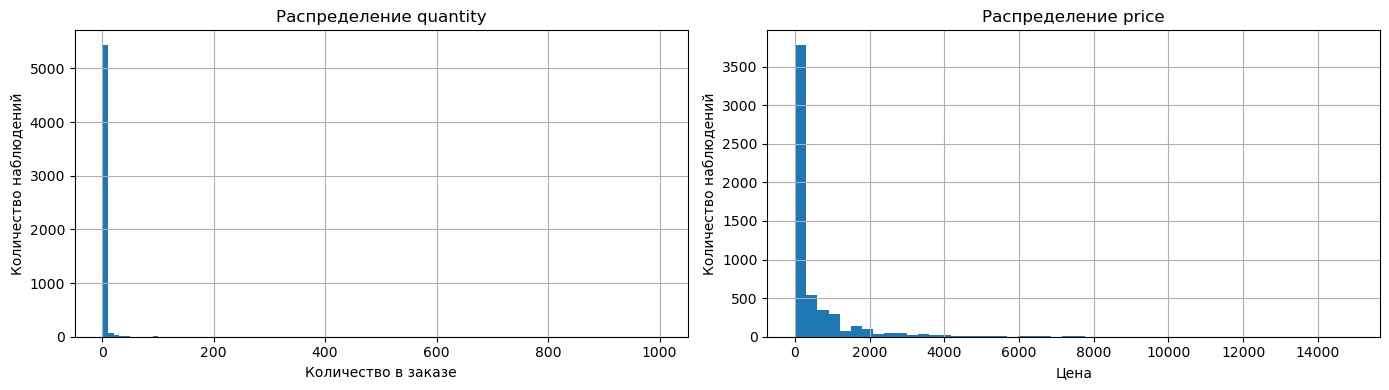

In [10]:

# создание сетки 1х2 для графиков
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Построение гистограммы для quantity
df['quantity'].hist(bins=100, ax=axes[0])
axes[0].set_title('Распределение quantity')
axes[0].set_xlabel('Количество в заказе')
axes[0].set_ylabel('Количество наблюдений')

# Построение гистограммы для price
df['price'].hist(bins=50, ax=axes[1])
axes[1].set_title('Распределение price')
axes[1].set_xlabel('Цена')
axes[1].set_ylabel('Количество наблюдений')

# Отображение графиков
plt.tight_layout()
plt.show()

- из графиков видим, что количества в подавляющем большинстве заказов - 1-10 шт. и единичные заказы с большим количеством товара. Цены тоже сконцентрированы до 500 р. Посмотрим на выбросы и решим, что с ними делать.


In [11]:
# выведем заказы, в которых более 100 шт. товара
qty_outliers = df[df['quantity']>100].sort_values(by='quantity', ascending=False)
print('Количество записей с количеством товара более 100 шт. - ', qty_outliers.shape[0])

display(qty_outliers.sort_values(by='order_id'))

Количество записей с количеством товара более 100 шт. -  9


,date,customer_id,order_id,product,quantity,price
241,2018-10-16 08:00:00,cd09ea73-d9ce-48c3-b4c5-018113735e80,68611,"Крепеж для пружины дверной, 1107055",150,19.0
242,2018-10-16 08:00:00,cd09ea73-d9ce-48c3-b4c5-018113735e80,68611,"Пружина дверная 240 мм оцинкованная (Д-19 мм) без крепления, 1107014",150,38.0
481,2018-11-01 08:00:00,aa42dc38-780f-4b50-9a65-83b6fa64e766,68815,Муляж ЯБЛОКО 9 см красное,170,51.0
499,2018-11-02 11:00:00,0c5aaa88-e346-4f87-8f7a-ad8cbc04e965,68831,Муляж ЯБЛОКО 9 см красное,140,59.0
1010,2018-12-10 14:00:00,a984c5b7-ff7e-4647-b84e-ef0b85a2762d,69289,"Ручка-скоба РС-100 белая *Трибатрон*, 1108035",200,29.0
2073,2019-03-23 10:00:00,685d3d84-aebb-485b-8e59-344b3df8b3d3,70841,Плечики пластмассовые Размер 52 - 54 Тула 1205158,150,20.0
3381,2019-05-20 21:00:00,5d189e88-d4d6-4eac-ab43-fa65a3c4d106,71478,Муляж ЯБЛОКО 9 см красное,300,51.0
3739,2019-06-11 07:00:00,146cd9bf-a95c-4afb-915b-5f6684b17444,71668,Вешалки мягкие для деликатных вещей 3 шт шоколад,334,148.0
3807,2019-06-18 15:00:00,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"Вантуз с деревянной ручкой d14 см красный, Burstenmann, 0522/0000",1000,675.0


- судя по всему, очевидно ошибочной является только запись с продажей 1000 шт. вантузов. Удалим ее и посмотрим, что еще покупали клиенты из этого списка

In [12]:
# удалим запись с вантузом 
df = df.drop(index=3807)

# Отображение строк в df, где customer_id присутствует в qty_outliers
display(df[df['customer_id'].isin(qty_outliers['customer_id'].unique())])


,date,customer_id,order_id,product,quantity,price
241,2018-10-16 08:00:00,cd09ea73-d9ce-48c3-b4c5-018113735e80,68611,"Крепеж для пружины дверной, 1107055",150,19.0
242,2018-10-16 08:00:00,cd09ea73-d9ce-48c3-b4c5-018113735e80,68611,"Пружина дверная 240 мм оцинкованная (Д-19 мм) без крепления, 1107014",150,38.0
481,2018-11-01 08:00:00,aa42dc38-780f-4b50-9a65-83b6fa64e766,68815,Муляж ЯБЛОКО 9 см красное,170,51.0
499,2018-11-02 11:00:00,0c5aaa88-e346-4f87-8f7a-ad8cbc04e965,68831,Муляж ЯБЛОКО 9 см красное,140,59.0
1010,2018-12-10 14:00:00,a984c5b7-ff7e-4647-b84e-ef0b85a2762d,69289,"Ручка-скоба РС-100 белая *Трибатрон*, 1108035",200,29.0
2073,2019-03-23 10:00:00,685d3d84-aebb-485b-8e59-344b3df8b3d3,70841,Плечики пластмассовые Размер 52 - 54 Тула 1205158,150,20.0
3381,2019-05-20 21:00:00,5d189e88-d4d6-4eac-ab43-fa65a3c4d106,71478,Муляж ЯБЛОКО 9 см красное,300,51.0
3739,2019-06-11 07:00:00,146cd9bf-a95c-4afb-915b-5f6684b17444,71668,Вешалки мягкие для деликатных вещей 3 шт шоколад,334,148.0


- эти клиенты совершили только одну покупку. Нельзя с уверенностью сказать, что 300 шт. муляжей красного яблока не могут понадобиться - например, в кино можно снимать в замедленной съемке дождь из яблок.. Поэтому оставим все эти записи и зададим вопросы коллегам, кто может прокомментировать заказы.

Посмотрим теперь на выбросы в цене

In [13]:
df['price'].describe()

count     5589.000000
mean       531.122935
std        973.169849
min          9.000000
25%         90.000000
50%        150.000000
75%        524.000000
max      14917.000000
Name: price, dtype: float64

In [14]:
# выведем заказы, в которых цена выше 75% персентиля - 524 р.
price_outliers = df[df['price']>524].sort_values(by='price', ascending=False)
print('Количество записей с ценами выше 524 р. - ', price_outliers.shape[0])

display(price_outliers)

Количество записей с ценами выше 524 р. -  1393


,date,customer_id,order_id,product,quantity,price
4195,2019-07-29 17:00:00,0d87f4ae-465a-4fac-81e6-5d629761783e,72139,Сушилка уличная Leifheit 85210 LINOMATIC V 400 40 м 175х237х237 см зеленая,1,14917.0
2301,2019-04-05 19:00:00,c0c60544-3a99-49d0-8a8e-cf7f293c22cb,71035,"Сумка-тележка хозяйственная Andersen Royal Shopper, Hera, синяя 166-004-90",1,8737.0
1695,2019-02-24 10:00:00,ac250053-a236-467a-97d2-ddbb9bf4a1ba,70423,"Сумка-тележка хозяйственная Andersen Alu Star Shopper, Hava, синяя 115-103-90",1,8437.0
2547,2019-04-21 16:00:00,19d904d8-8d16-476d-8f66-b2a3b7a23660,71227,Сумка-тележка хозяйственная Rolser MNB019 rojo LOGIC DOS+2 красная,1,8077.0
5552,2020-01-26 19:00:00,04416514-5346-4f90-93e3-fb7365e2ee8c,109758,Сумка-тележка хозяйственная Rolser MNB019 rojo LOGIC DOS+2 красная,1,8077.0
...,...,...,...,...,...,...
146,2018-10-09 15:00:00,f5c28991-8268-4e71-a71e-28b98a9ac5f9,68588,Комплект для ванной и туалета Dasch 50х80 см и 55х55 см TL-2-E Лавр бежевый 5755,1,525.0
4327,2019-08-18 16:00:00,b20e2d32-dd9d-49f1-9300-dee4c3dfee26,72336,"Тележка хозяйственная складная, ТХ0253, 50 кг, Пэмби",1,525.0
5491,2020-01-18 18:00:00,ec964a80-31f3-4411-a468-6e33cb417f15,103714,Комплект для ванной и туалета Dasch 50х80 см и 55х55 см TL-2-E Лавр бежевый 5755,1,525.0
4278,2019-08-12 21:00:00,03427797-398e-497d-a303-48879e7ba7f7,72269,"Тележка хозяйственная складная, ТХ0253, 50 кг, Пэмби",1,525.0


- ничего подозрительного, для цен хозтоваров суммы более 10000 р. не редкость. Сумки и сушилки бывают и дороже. Посмотрим на самые низкие цены - ниже 10 р.

In [15]:
# выведем заказы, в которых цена выше 75% персентиля - 524 р.
price_outliers = df[df['price']<=10].sort_values(by='price', ascending=True)
print('Количество записей с ценами 10 р. и ниже. - ', price_outliers.shape[0])

display(price_outliers)

Количество записей с ценами 10 р. и ниже. -  23


,date,customer_id,order_id,product,quantity,price
933,2018-12-03 11:00:00,2c8b9386-2e8c-4ee9-8aa4-2b4875b68578,14514,"Алиссум (лобулярия) Снежные одежды 0,2 г 4650091480302",2,9.0
942,2018-12-03 11:00:00,2c8b9386-2e8c-4ee9-8aa4-2b4875b68578,14514,"Львиный зев Волшебный ковер 0,05 г 4660010779639",1,9.0
5189,2019-12-17 12:00:00,1f7a71e2-0e7a-47ee-89d8-320b6315f4c7,107078,"Львиный зев Волшебный ковер 0,05 г 4660010779639",1,9.0
1853,2019-03-04 15:00:00,0f47231c-3a68-404a-88f7-08a4a172c17f,14559,"Горох Амброзия 10,0 г 4660010772616",1,9.0
3930,2019-07-03 22:00:00,1ec1ad59-a29b-4949-929d-f4fc4fe14758,14887,"Алиссум (лобулярия) Снежные одежды 0,2 г 4650091480302",1,9.0
852,2018-11-25 14:00:00,52aff75c-a972-4c25-bad5-dfe6a48cd981,14512,Морковь Детская сладость 2 г 4660010775921,1,10.0
5395,2020-01-08 16:00:00,aa7151ae-8da0-41ca-85b6-5c1b331d5bdc,107324,"Укроп Обильнолистный 3,0 г 4660010772562",1,10.0
5268,2019-12-27 22:00:00,03134fa3-9ce0-4973-849d-32c21e26d64e,111690,"Незабудка смесь 0,1 г 4650091480340",1,10.0
5186,2019-12-17 09:00:00,7f5f1b8f-d7be-46d5-a1f7-e15d3d72a3f7,105745,"Томат Балконное чудо 0,1 г 4660010772531",1,10.0
5086,2019-12-02 16:00:00,c42ba183-9dfe-4b9b-a572-3624973eab54,112689,"Незабудка смесь 0,1 г 4650091480340",1,10.0


- судя по названиям, это семена, маленькие пакетики, нормальные для них цены.

С выбросами и ошибками в количествах и ценах разобрались, удалили 1000 вантузов, идем далее.

### Формирование новых полей даты/времени на основе существующих данных

- выделим в отдельные колонки **год, месяц, пару год-месяц, день недели и час**, для использования в дальнейших исследованиях

In [16]:
# выделим час заказа и день недели
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Форматирование пары год-месяц с ведущим нулем
df['year_month'] = df['date'].dt.strftime('%Y-%m')
df['weekday'] = df['date'].dt.weekday # 0 - понедельник, 6 - воскресенье
df['hour'] = df['date'].dt.hour

display(df.head(10))

,date,customer_id,order_id,product,quantity,price,year,month,year_month,weekday,hour
0,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,2018,10,2018-10,0,0
1,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194.0,2018,10,2018-10,0,0
2,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,2018,10,2018-10,0,0
3,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,2018,10,2018-10,0,0
4,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,2018,10,2018-10,0,0
5,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Шеффлера Лузеана d-9 см,1,164.0,2018,10,2018-10,0,0
6,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Юкка нитчатая d-12 см h-25-35 см,1,134.0,2018,10,2018-10,0,0
7,2018-10-01 08:00:00,375e0724-f033-4c76-b579-84969cf38ee2,68479,Настенная сушилка для белья Gimi Brio Super 100,1,824.0,2018,10,2018-10,0,8
8,2018-10-01 08:00:00,6644e5b4-9934-4863-9778-aaa125207701,68478,"Таз пластмассовый 21,0 л круглый ""Водолей"" С614, 1404056",1,269.0,2018,10,2018-10,0,8
9,2018-10-01 09:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,68480,Чехол для гладильной доски Colombo Persia Beige 130х50 см из хлопка 5379,1,674.0,2018,10,2018-10,0,9


### Обработка и категоризация названий продуктов

- для полноценного анализа продаж нам надо разбить товары на категории. Посмотрим, сколько уникальных названий товаров у нас есть

In [17]:
print('Уникальных товаров - ', df['product'].nunique())

Уникальных товаров -  2342


In [18]:
# теперь удалим все знаки препинания, цифры и прочие символы из названий, приведем в прописной вид и сохраним в новой колонке, оставив первые 3 слова кириллицей

# Напишем функцию с использованием Regex
def process_text(text):
    # Удаляем все, кроме букв кириллицы, и приводим к нижнему регистру
    text = re.sub(r'[^а-яА-ЯёЁ\s]', '', text).lower()

    # Разбиваем текст на слова
    words = text.split()

    # Оставляем только первые три слова, если они на кириллице и не являются стоп-словами
    result = []
    count = 0
    for word in words:
        if re.match(r'^[а-яё]+$', word) and word not in russian_stopwords and word not in ['л','см','кг','мм', 'м', 'г']:
            result.append(word)
            count += 1
            if count == 3:
                break

    return ' '.join(result)

# Пример использования
text = "Тележка багажная DELTA DT-22 синий грузоподъемность 20 кг сумка и 50 кг каркас РОССИЯ"
processed_text = process_text(text)
print(processed_text)


тележка багажная синий


In [19]:
# применим функцию к колонке с названиями
df['product_3_words'] = df['product'].apply(process_text)
display(df.head(10))

,date,customer_id,order_id,product,quantity,price,year,month,year_month,weekday,hour,product_3_words
0,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,2018,10,2018-10,0,0,комнатное растение горшке
1,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194.0,2018,10,2018-10,0,0,комнатное растение горшке
2,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,2018,10,2018-10,0,0,радермахера
3,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,2018,10,2018-10,0,0,хризолидокарпус лутесценс
4,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,2018,10,2018-10,0,0,циперус зумула
5,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Шеффлера Лузеана d-9 см,1,164.0,2018,10,2018-10,0,0,шеффлера лузеана
6,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Юкка нитчатая d-12 см h-25-35 см,1,134.0,2018,10,2018-10,0,0,юкка нитчатая
7,2018-10-01 08:00:00,375e0724-f033-4c76-b579-84969cf38ee2,68479,Настенная сушилка для белья Gimi Brio Super 100,1,824.0,2018,10,2018-10,0,8,настенная сушилка белья
8,2018-10-01 08:00:00,6644e5b4-9934-4863-9778-aaa125207701,68478,"Таз пластмассовый 21,0 л круглый ""Водолей"" С614, 1404056",1,269.0,2018,10,2018-10,0,8,таз пластмассовый круглый
9,2018-10-01 09:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,68480,Чехол для гладильной доски Colombo Persia Beige 130х50 см из хлопка 5379,1,674.0,2018,10,2018-10,0,9,чехол гладильной доски


- в нашем списке много растений, предположительно. Попробуем взять названия из справочника растений в интернете (https://www.cnshb.ru/AKDiL/0016/default.shtm)<br>
все растения там собраны по видам и названиям в виде ссылок, будем искать их в парсинге.


In [20]:
# URL начальной страницы
base_url = "https://www.cnshb.ru/AKDiL/0016/"
start_url = f"{base_url}default.shtm"

# Функция для извлечения названий растений с одной страницы
def extract_plant_names(url):
    try:
        response = requests.get(url, timeout=10)  # запрашиваем HTML код страницы и устанавливаем тайм-аут в 10 секунд
        response.encoding = 'windows-1251'

        # response.text: это текстовое содержимое HTTP-ответа, полученного с помощью библиотеки requests. Оно содержит HTML-код страницы.
        # мы создаем объект BeautifulSoup, который позволяет нам парсить HTML-документ. В данном случае мы используем парсер 'html.parser', встроенный в библиотеку #BeautifulSoup. Он достаточно быстрый и не требует дополнительных установок
        soup = BeautifulSoup(response.text, 'html.parser')

        # soup.find_all('a'): метод find_all находит все теги <a> в HTML-документе. Тег <a> используется для создания гиперссылок.
        # [a.get_text(strip=True) for a in ... if ...]: это list comprehension (генератор списка), который позволяет создать новый список на основе существующего.
        # a.get_text(strip=True): метод get_text извлекает весь текст, содержащийся внутри тега <a>. Параметр strip=True удаляет начальные и конечные пробелы из этого текста.
        #if a.get_text(strip=True): этот условный оператор гарантирует, что в новый список попадут только те элементы, у которых есть непустой текст
        plant_names = [a.get_text(strip=True) for a in soup.find_all('a') if a.get_text(strip=True)]
        
        return plant_names
    except requests.exceptions.RequestException as e:
        print(f"Ошибка при запросе {url}: {e}")
        return []

# Отправляем запрос на начальную страницу
try:
    response = requests.get(start_url, timeout=10)  # Устанавливаем тайм-аут в 10 секунд
    response.encoding = 'windows-1251'
    soup = BeautifulSoup(response.text, 'html.parser')

    # Ищем все ссылки на страницы с названиями растений, которые начинаются на 'ks'
    # soup.find_all('a', href=True): метод find_all находит все теги <a> (гиперссылки) в HTML-документе, у которых есть атрибут href. Таким образом, фильтруются только те  #теги <a>, которые содержат ссылку, начинающуюся с base/ks.
    links = [base_url + a['href'] for a in soup.find_all('a', href=True) if a['href'].startswith('base/ks')]

    # Извлекаем названия растений с каждой страницы
    all_plant_names = []
    for link in links:
        all_plant_names.extend(extract_plant_names(link))

    # Создаем DataFrame
    df_plants = pd.DataFrame(all_plant_names, columns=['Plant Name'])

    # Сохраняем DataFrame в CSV файл
    df_plants.to_csv('all_plant_names.csv', index=False)

    # Выводим первые 10 строк DataFrame
    display(df_plants.head(20))

except requests.exceptions.RequestException as e:
    print(f"Ошибка при запросе {start_url}: {e}")


,Plant Name
0,"Энциклопедии, словари, справочники (поиск)"
1,Справочник растений
2,Читатели спрашивают
3,1. CycasL. —Саговник
4,"Энциклопедии, словари, справочники (поиск)"
5,Справочник растений
6,Читатели спрашивают
7,2. GinkgoL. —Гинкго
8,"Энциклопедии, словари, справочники (поиск)"
9,Справочник растений


In [21]:
# Функция для извлечения русской части названия и удаления ненужных записей
def extract_russian_name(plant_name):
    match = re.search(r'—\s*([\w\s]+)$', plant_name) # ищем записи, где в конце строки есть тире и слово (....— Гнетум) и берем это слово
    return match.group(1).strip() if match else None # нашли название после тире - возвращаем его, иначе none 

# Применение функции к колонке 'Plant Name'
df_plants['russian_name'] = df_plants['Plant Name'].apply(extract_russian_name)

# Удаление строк с None (т.е. не содержащих названия растений)
df_plants = df_plants.dropna(subset=['russian_name']).reset_index(drop=True)

# Сохранение в CSV файл
df_plants.to_csv('filtered_plant_names.csv', index=False)

# Вывод первых 10 строк DataFrame
print(df_plants.head(50))


                                 Plant Name       russian_name
0                      1. CycasL. —Саговник           Саговник
1                       2. GinkgoL. —Гинкго             Гинкго
2                  3. Тоггеуа Агп. — Торрея             Торрея
3      4. Cunninghamia R. Br. — Куннингамия        Куннингамия
4                     5. Gnetum L. — Гнетум             Гнетум
5                   6. Ephedra L. — Хвойник            Хвойник
6       7. Pandanus (Rumph.) L. f. — Пандан             Пандан
7                 8. Potamogeton L. — Рдест              Рдест
8        9. Groenlandia J. Gay — Гренландия         Гренландия
9                     10. Ruppia L. — Рушшя              Рушшя
10                11. Zostera L. — Взморник           Взморник
11   12. Sagittaria (Rupr.) L. — Стрелолист         Стрелолист
12         13. Euchlaena Schrad. — Теосинте           Теосинте
13                         14. Zea L. — Зеа                Зеа
14             15. Tripsacum L. — Трипсакум          Тр

- отлично, сейчас попробуем прогнать наши названия продуктов через проверку принадлежности списку растений и присвоим категорию "Растения" найденным. Но сначала присвоим категорию "Семена" продуктам, где фигурирует **"хх.х г"** - это признак того что это семена растений, вес в граммах

In [22]:
# присвоим категорию "Семена" продуктам, где в названии содержится вес в граммах.

# Функция для определения категории
def assign_category_seeds(product):
    if re.search(r'\b\d+,\d+\s*г\b|\b\d+\s*г\b', product): # ищем текст вида "1,5 г" или "3 г"
        return "Семена"
    return "Другое"

# Применение функции к колонке 'product'
df['category'] = df['product'].apply(assign_category_seeds)

print('Записей с категорией Семена - ', df[df['category']=='Семена'].shape[0])

# Вывод DataFrame для проверки результата
display(df.sort_values(by='price', ascending=True))

Записей с категорией Семена -  90


,date,customer_id,order_id,product,quantity,price,year,month,year_month,weekday,hour,product_3_words,category
1853,2019-03-04 15:00:00,0f47231c-3a68-404a-88f7-08a4a172c17f,14559,"Горох Амброзия 10,0 г 4660010772616",1,9.0,2019,3,2019-03,0,15,горох амброзия,Семена
942,2018-12-03 11:00:00,2c8b9386-2e8c-4ee9-8aa4-2b4875b68578,14514,"Львиный зев Волшебный ковер 0,05 г 4660010779639",1,9.0,2018,12,2018-12,0,11,львиный зев волшебный,Семена
5189,2019-12-17 12:00:00,1f7a71e2-0e7a-47ee-89d8-320b6315f4c7,107078,"Львиный зев Волшебный ковер 0,05 г 4660010779639",1,9.0,2019,12,2019-12,1,12,львиный зев волшебный,Семена
3930,2019-07-03 22:00:00,1ec1ad59-a29b-4949-929d-f4fc4fe14758,14887,"Алиссум (лобулярия) Снежные одежды 0,2 г 4650091480302",1,9.0,2019,7,2019-07,2,22,алиссум лобулярия снежные,Семена
933,2018-12-03 11:00:00,2c8b9386-2e8c-4ee9-8aa4-2b4875b68578,14514,"Алиссум (лобулярия) Снежные одежды 0,2 г 4650091480302",2,9.0,2018,12,2018-12,0,11,алиссум лобулярия снежные,Семена
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5552,2020-01-26 19:00:00,04416514-5346-4f90-93e3-fb7365e2ee8c,109758,Сумка-тележка хозяйственная Rolser MNB019 rojo LOGIC DOS+2 красная,1,8077.0,2020,1,2020-01,6,19,сумкатележка хозяйственная красная,Другое
2547,2019-04-21 16:00:00,19d904d8-8d16-476d-8f66-b2a3b7a23660,71227,Сумка-тележка хозяйственная Rolser MNB019 rojo LOGIC DOS+2 красная,1,8077.0,2019,4,2019-04,6,16,сумкатележка хозяйственная красная,Другое
1695,2019-02-24 10:00:00,ac250053-a236-467a-97d2-ddbb9bf4a1ba,70423,"Сумка-тележка хозяйственная Andersen Alu Star Shopper, Hava, синяя 115-103-90",1,8437.0,2019,2,2019-02,6,10,сумкатележка хозяйственная синяя,Другое
2301,2019-04-05 19:00:00,c0c60544-3a99-49d0-8a8e-cf7f293c22cb,71035,"Сумка-тележка хозяйственная Andersen Royal Shopper, Hera, синяя 166-004-90",1,8737.0,2019,4,2019-04,4,19,сумкатележка хозяйственная синяя,Другое


- отлично, теперь прогоним через список растений, что мы взяли из интернета

In [23]:
# Функция для определения категории "Растения"
def assign_category_plants(row):
    if row['category'] == "Семена":
        return row['category']
    product_words = row['product'].split()
    for word in product_words:
        if word in df_plants['russian_name'].values:
            return "Растения"
    if re.search(r'\b[dh][-]?\d+\s*[см]?\b', row['product']): # дополнительно добавим проверку на наличие обозначений диаметра и/или высоты 'Комнатное растение в горшке Кофе Арабика, d12, h25'
        return "Растения"
    return "Другое"

# Применение функции к строкам DataFrame для присвоения категории "Растения" и "Другое"
df['category'] = df.apply(assign_category_plants, axis=1)

# Вывод DataFrame для проверки результата
display(df[df['category']=='Растения'].sort_values(by='price', ascending=True))

,date,customer_id,order_id,product,quantity,price,year,month,year_month,weekday,hour,product_3_words,category
5198,2019-12-18 15:00:00,53edf382-efb5-4114-941d-45937f4a346f,110867,Календула Бронзовая красавица 10 шт 4650091480746,1,11.0,2019,12,2019-12,2,15,календула бронзовая красавица,Растения
2118,2019-03-28 10:00:00,56f19ebf-c69b-4482-8cda-cc184f16e7f0,14595,Календула Бронзовая красавица 10 шт 4650091480746,2,11.0,2019,3,2019-03,3,10,календула бронзовая красавица,Растения
2277,2019-04-04 15:00:00,73495642-a43a-4cd1-b918-930683461cd1,71008,Базилик зеленый Тонус d-7 см,10,14.0,2019,4,2019-04,3,15,базилик зеленый тонус,Растения
3673,2019-06-06 20:00:00,cab090a5-b8dd-442d-a206-0ef3bf5fc1d8,71634,Базилик Овощной Арарат d-7 см,1,14.0,2019,6,2019-06,3,20,базилик овощной арарат,Растения
4193,2019-07-29 07:00:00,70b5d46f-1ee0-404d-824e-31223a6eed0b,72133,Базилик Пурпурные Звезды d-7 см,3,14.0,2019,7,2019-07,0,7,базилик пурпурные звезды,Растения
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1905,2019-03-06 16:00:00,6ff8b2d3-82b0-41dd-aae2-f15d9875963e,70567,Эвкалипт Гунни d-17 см h-60 см,1,1762.0,2019,3,2019-03,2,16,эвкалипт гунни,Растения
2225,2019-04-02 15:00:00,d3a1a9d9-4a3f-4c18-bfb2-0d23abf348bc,70978,Эвкалипт Гунни d-17 см h-60 см,1,1762.0,2019,4,2019-04,1,15,эвкалипт гунни,Растения
2383,2019-04-10 15:00:00,3270f879-7932-410c-ac87-82ff83ea457b,71091,Цитрофортунелла Кумкват штамбовая d-21 см h-75 см,1,3074.0,2019,4,2019-04,2,15,цитрофортунелла кумкват штамбовая,Растения
5072,2019-11-30 15:00:00,1cd0c18d-5437-400d-9a64-d0f8ba25f596,110689,Цитрофортунелла Кумкват штамбовая d-21 см h-75 см,1,3074.0,2019,11,2019-11,5,15,цитрофортунелла кумкват штамбовая,Растения


Посмотрим, какие категории остались

In [24]:
display(df[df['category']=='Другое'])

,date,customer_id,order_id,product,quantity,price,year,month,year_month,weekday,hour,product_3_words,category
7,2018-10-01 08:00:00,375e0724-f033-4c76-b579-84969cf38ee2,68479,Настенная сушилка для белья Gimi Brio Super 100,1,824.0,2018,10,2018-10,0,8,настенная сушилка белья,Другое
8,2018-10-01 08:00:00,6644e5b4-9934-4863-9778-aaa125207701,68478,"Таз пластмассовый 21,0 л круглый ""Водолей"" С614, 1404056",1,269.0,2018,10,2018-10,0,8,таз пластмассовый круглый,Другое
9,2018-10-01 09:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,68480,Чехол для гладильной доски Colombo Persia Beige 130х50 см из хлопка 5379,1,674.0,2018,10,2018-10,0,9,чехол гладильной доски,Другое
10,2018-10-01 11:00:00,161e1b98-45ba-4b4e-8236-e6e3e70f6f7c,68483,"Вешалка для брюк металлическая с резиновым покрытием 26 см цвет: синяя, Attribute, AHS331",10,82.0,2018,10,2018-10,0,11,вешалка брюк металлическая,Другое
11,2018-10-01 12:00:00,86432d8d-b706-463b-bd5d-6a9e170daee3,68484,"Сушилка для белья потолочная Zalger Lift Basic 1520 200 см, 10 м",1,614.0,2018,10,2018-10,0,12,сушилка белья потолочная,Другое
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5583,2020-01-29 17:00:00,4228e34b-dcba-4df8-ae70-b282e84a1edb,110547,Tepмокружка AVEX Freeflow 700 мл зеленый AVEX0759,1,2399.0,2020,1,2020-01,2,17,мокружка мл зеленый,Другое
5585,2020-01-30 21:00:00,63208953-a8e4-4f77-9b47-3a46e7b72eee,104002,томата (помидор) Черниченский черри № 116 сорт индетерминантный позднеспелый черный,2,38.0,2020,1,2020-01,3,21,томата помидор черниченский,Другое
5587,2020-01-31 02:00:00,2c9bd08d-8c55-4e7a-9bfb-8c56ba42c6d6,106336,Подставка для обуви резиновая Attribute 80x40 см AMC080,1,354.0,2020,1,2020-01,4,2,подставка обуви резиновая,Другое
5588,2020-01-31 12:00:00,cdd17932-623e-415f-a577-3b31312fd0e2,102002,Тагетис крупноцветковый рассада однолетних цветов в кассете по 6 шт,1,128.0,2020,1,2020-01,4,12,тагетис крупноцветковый рассада,Другое


- Придется присваивать категории вручную по ключевым словам в колонке `product_3_words`. Поехали!

In [25]:
# набросаем распределение по категориям по частям ключевых слов
bath = ['туал', 'ванн', 'сануз', 'сантех', "унитаз", "мыл", "вантуз", "штора", "штанг", "халат"]
home = ['скатер', "вешал", "плечик", "таз", "корзин", "подставк", "наматрас", "простын", "одеял", "наволоч", "крюч", "прищеп", "котел", "ковр", "перча", "плед", "подуш", "ковш", "бидон", "контейн", "полк", "шваб", "ведр", "ящик", "этажер", "весы", "постел", "карниз", "веник", "средство", "кофр", "крем", "светил", "покрыв", "короб", "урна", "ролик", "бак", "обувниц", "комод", "ключн", "мыт", "наматрас"]
dryer = ['сушил']
iron = ['гладил', "утюг", "чехол", "подрука"]
cart = ["тележ", "сумка"]
kitchen = ['посуд', "вилк", "ложк", "нож", "столов", "тарел", "чашк", 'круж', "кух", "выпеч", "орехокол", "чай", "сотей", "фужер", "ёрш", "толкуш", "крышк", "банк", "салф", "против", "чай", "микс", "кастр", "сковоро", "салат", "хлеб", "миска", "стакан", "свч", "терка", "термос", "блюд", "щетк", "бокал", "рыбочи", "овощевар", "лопат", "овощ", "губк", "мантов", "сито", "просе", "скал", "раздело"]
furniture = ["крепеж", "скоба", "дверн", "оконн", "петля", "шпингалет", "мебель", "заверт"]
seedling = ["рассада", "томат"]
fakes = ["муляж", "искусств", "искуств"]
plants = ['настурц', "геран", "растен", "пеларго", "вербен", "петун", "цинни", "корианд", "афеля", "примул", "фукс", "калибрах", "бегон", "седум", "клубн", "осин", "ранунк", "цикламе", "пуансетт", "флокс", "камнелом", "роза", "космея", "декабрист", "физост", "энотера"]
tools = ["сметка", "стремян", "штанге", "свер", "фал", "окномо", "инструм", "угольник", "линей"]

def other_categories(row):
    if row['category'] == 'Другое':
        product_words = row['product_3_words'].split()
        for word in product_words:
            if any(b in word.lower() for b in bath):
                return "Сантехника"
        for word in product_words:
            if any(b in word.lower() for b in home):
                return "Хозтовары"
        for word in product_words:
            if any(b in word.lower() for b in dryer):
                return "Сушилки"
        for word in product_words:
            if any(b in word.lower() for b in iron):
                return "Принадлежности для глажения"
        for word in product_words:
            if any(b in word.lower() for b in cart):
                return "Тележки и сумки"
        for word in product_words:
            if any(b in word.lower() for b in kitchen):
                return "Посуда и кухонные принадлежности"
        for word in product_words:
            if any(b in word.lower() for b in furniture):
                return "Фурнитура"
        for word in product_words:
            if any(b in word.lower() for b in seedling):
                return "Рассада"
        for word in product_words:
            if any(b in word.lower() for b in fakes):
                return "Муляжи"
        for word in product_words:
            if any(b in word.lower() for b in plants):
                return "Растения"
        for word in product_words:
            if any(b in word.lower() for b in tools):
                return "Инструменты"
       
    return row['category']

# Применение функции к колонке 'product_3_words'
df['category'] = df.apply(other_categories, axis=1)
    

In [26]:
display(df[df['category']=='Другое'].sample(10, random_state=42).sort_values(by="price", ascending=False))

,date,customer_id,order_id,product,quantity,price,year,month,year_month,weekday,hour,product_3_words,category
4431,2019-09-04 18:00:00,c75052a0-1bd3-40b4-8c41-05208207f79e,72504,Соковарка WEBBER ВЕ-06 из нержавеющей стали 6 л,1,1949.0,2019,9,2019-09,2,18,соковарка ве нержавеющей,Другое
4485,2019-09-12 17:00:00,62cd9806-c1c8-40ca-b41c-cdd9151a242c,72608,Махровое полотенце 34х34 см WELLNESS EXCLUSIVE ДАККИ-31 100% хлопок,4,149.0,2019,9,2019-09,3,17,махровое полотенце х,Другое
2291,2019-04-05 12:00:00,cca3f0b3-fede-4ece-8b0e-096175e5a54a,14619,"Платикодон махровый синий объем 0,5 л",2,112.0,2019,4,2019-04,4,12,платикодон махровый синий,Другое
2881,2019-05-02 16:00:00,760aa067-90c3-4794-b7a9-a8831197388b,14715,Кореопсис Золотой маяк желтый объем 1 л,1,112.0,2019,5,2019-05,3,16,кореопсис золотой маяк,Другое
2098,2019-03-25 14:00:00,470bf3f8-7b9c-4cd9-bd59-24dbc13495e5,14590,Овсянница сизая серый объем 1 л,1,89.0,2019,3,2019-03,0,14,овсянница сизая серый,Другое
5444,2020-01-15 13:00:00,bf80a4e0-d337-4117-8552-064ed7a69b5e,109802,"Бензин для зажигалок, 1205214",2,67.0,2020,1,2020-01,2,13,бензин зажигалок,Другое
1243,2019-01-07 20:00:00,6a66aff9-2c2f-4051-a789-84e05f722823,69730,"Бензин для зажигалок, 1205214",2,67.0,2019,1,2019-01,0,20,бензин зажигалок,Другое
1120,2018-12-20 21:00:00,b1ffe573-6986-4e2d-9a93-90e49486902a,69490,Кольца для штор Виолет 12 шт пластик 1212/60,1,44.0,2018,12,2018-12,3,21,кольца штор виолет,Другое
4154,2019-07-24 09:00:00,f0982d05-99ee-400c-ac76-931ef7736374,72092,"Шнур хозяйственный 2 мм х 20 м цветной (Б) , 1201013",2,29.0,2019,7,2019-07,2,9,шнур хозяйственный х,Другое
3494,2019-05-28 13:00:00,f9d19e1d-9414-485b-9d8d-02bc196a88e8,71539,"Насадка на валик ВММ-200/60 белый искусственный мех, 0703011",70,22.0,2019,5,2019-05,1,13,насадка валик вмм,Другое


- посмотрим, сколько продуктов удалось категоризовать:

In [27]:
for category in df['category'].unique():
    print(category, ': ', df[df['category']==category].shape[0])

print("Всего записей: ", df.shape[0])

Растения :  2097
Сушилки :  310
Хозтовары :  655
Принадлежности для глажения :  293
Тележки и сумки :  388
Посуда и кухонные принадлежности :  544
Муляжи :  162
Рассада :  543
Семена :  90
Сантехника :  246
Фурнитура :  33
Инструменты :  74
Другое :  154
Всего записей:  5589


всего 154 записи попали в категорию "Другое" - это менее 3% от общего их количества. Остальные записи категоризованы. Считаю, что на этом можно остановиться.

- посмотрим на графике для наглядности количество уникальных продуктов в каждой категории и долю от общего количества продуктов:

Всего уникальных товаров: 2342


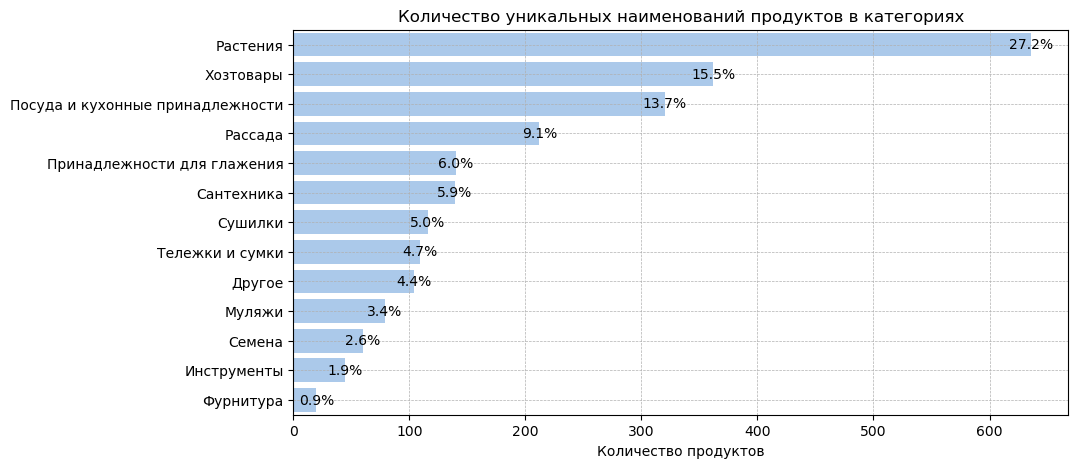

In [28]:
total_products = df['product'].nunique()
df_categories = df.groupby('category').agg(unique_products=('product','nunique')).sort_values(by='unique_products', ascending=False).reset_index()
df_categories['prc_from_total'] = df_categories['unique_products'] * 100 / total_products 

print('Всего уникальных товаров:', df['product'].nunique())

# Установка размера фигуры
plt.figure(figsize=(10, 5))

# Установка цветовой палитры
sns.set_color_codes("pastel")

# Создание barplot
ax = sns.barplot(x="unique_products", y="category", data=df_categories, color="b")

# Установка заголовка и меток осей
plt.title('Количество уникальных наименований продуктов в категориях')
plt.xlabel('Количество продуктов')
plt.ylabel('')

# Добавление аннотаций с процентами
for index, row in df_categories.sort_values(by='unique_products', ascending=False).iterrows():
    ax.annotate(f"{row['prc_from_total']:.1f}%", (row['unique_products'], index), ha='center', va='center', color='black')

# Добавление сетки
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Отображение графика
plt.show()

- видим из графика, что почти треть от всех продуктов в ассортименте составляют `растения`. на втором и третьем местах = `хозтовары`, `посуда и кухонные принадлежности`. Товары в категории `другое` занимают 4.4%

Построим графики продаж по категориям

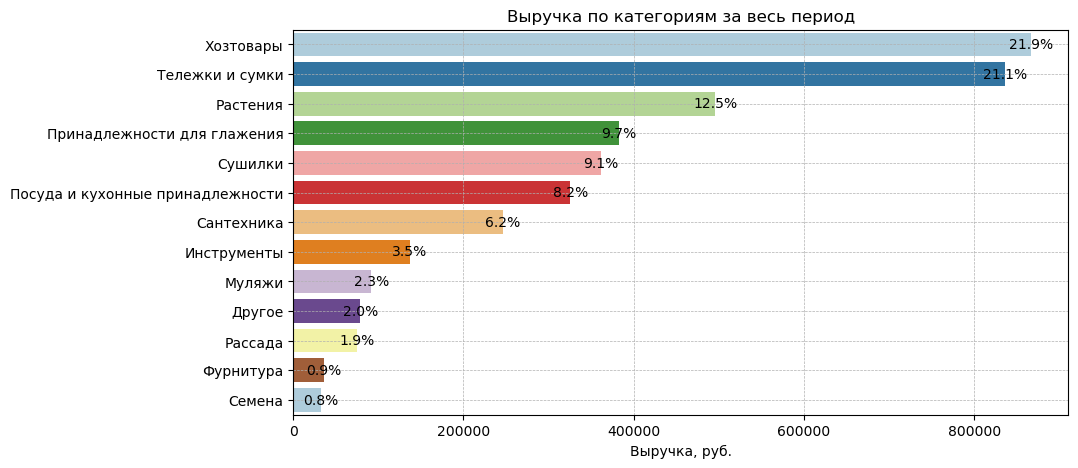

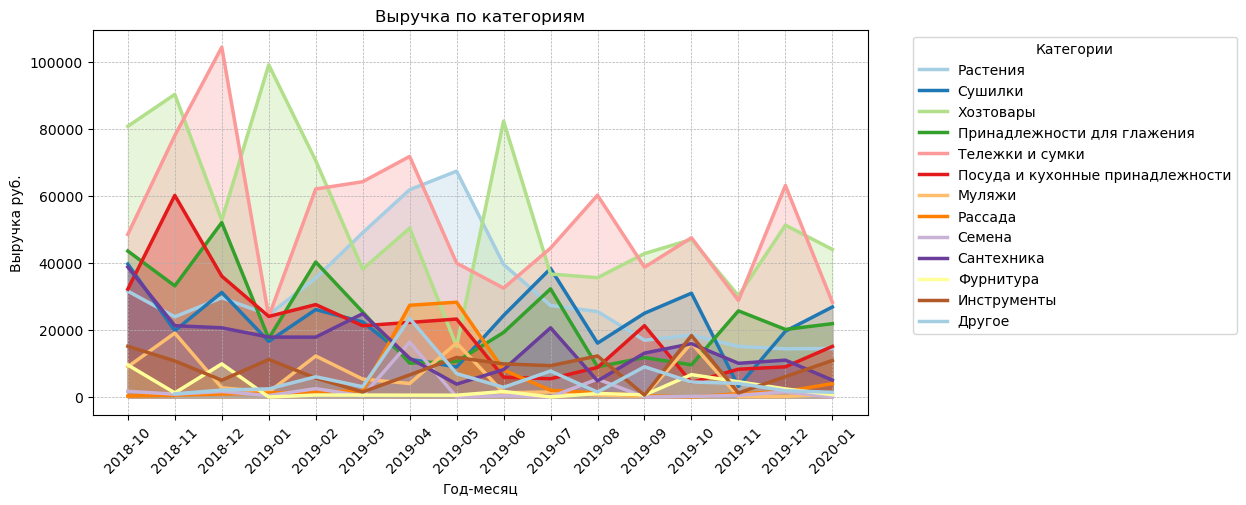

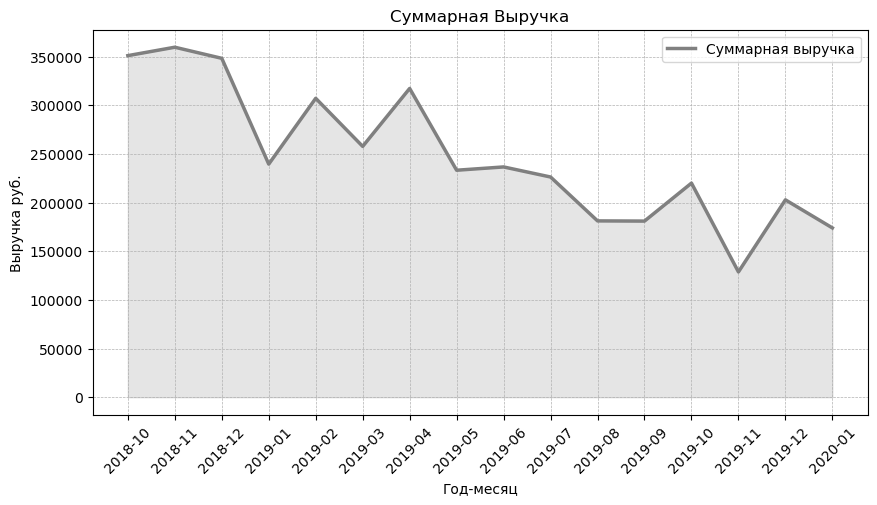

In [29]:
# добавим колонку с выручкой 
df['revenue'] = df['quantity'] * df['price']

total_revenue = df['revenue'].sum()

# Агрегирование данных
agg_data = df.groupby('category').agg(revenue=('revenue', 'sum')).sort_values(by='revenue', ascending=False).reset_index()
agg_data['prc_from_total'] = agg_data['revenue'] * 100 / total_revenue 

# Создание графика общей выручки по категориям
plt.figure(figsize=(10, 5))

# Выбор цветов для линий
colors = sns.color_palette('Paired', n_colors=len(df['category'].unique()))

sns.barplot(data=agg_data, y='category', x='revenue', palette=colors)

# Установка заголовка и меток осей
plt.title('Выручка по категориям за весь период')
plt.xlabel('Выручка, руб.')
plt.ylabel('')

# Добавление аннотаций с процентами
for index, row in agg_data.sort_values(by='revenue', ascending=False).iterrows():
    plt.annotate(f"{row['prc_from_total']:.1f}%", (row['revenue'], index), ha='center', va='center', color='black')

# Добавление сетки
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Отображение графика
plt.show()
# ------------------------------------------------------------------------------------------------

# Создание графика
plt.figure(figsize=(10, 5))

# Выбор цветов для линий
colors = sns.color_palette('Paired', n_colors=len(df['category'].unique()))

# Перебор категорий и построение графиков
for i, category in enumerate(df['category'].unique()):
    df_category = df.query('category == @category').groupby('year_month').agg(revenue=('revenue', 'sum')).sort_index()
    sns.lineplot(data=df_category, x=df_category.index, y='revenue', label=category, color=colors[i], linewidth=2.5)
    plt.fill_between(df_category.index, df_category['revenue'], alpha=0.3, color=colors[i])

# Установка заголовка и меток осей
plt.title('Выручка по категориям')
plt.xlabel('Год-месяц')
plt.ylabel('Выручка руб.')

# Поворот меток на оси x
plt.xticks(rotation=45)

# Добавление сетки
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Добавление легенды и вынесение её за пределы графика справа
plt.legend(title='Категории', bbox_to_anchor=(1.05, 1), loc='upper left')

# Отображение графика
plt.show()

# ------------------------------------------------------------------------------------------------

# Создание графика
plt.figure(figsize=(10, 5))

# Выбор цветов для линий
colors = sns.color_palette('Paired', n_colors=len(df['category'].unique()))

df_total = df.groupby('year_month').agg(total_revenue=('revenue', 'sum')).sort_index()
sns.lineplot(data=df_total, x=df_total.index, y='total_revenue', label='Суммарная выручка', color='grey', linewidth=2.5)
plt.fill_between(df_total.index, df_total['total_revenue'], alpha=0.1, color='black')

# Установка заголовка и меток осей
plt.title('Суммарная Выручка')
plt.xlabel('Год-месяц')
plt.ylabel('Выручка руб.')

# Поворот меток на оси x
plt.xticks(rotation=45)

# Добавление сетки
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

- 2 главные группы по выручке - **хозтовары, тележки и сумки**. **Растения** растут в продажах к сезону - апрелю/маю, далее начинается спад. Также  можно отметить общий спад продажна графике видны , который будет более подробно раскрыт на следующей визуализации: 

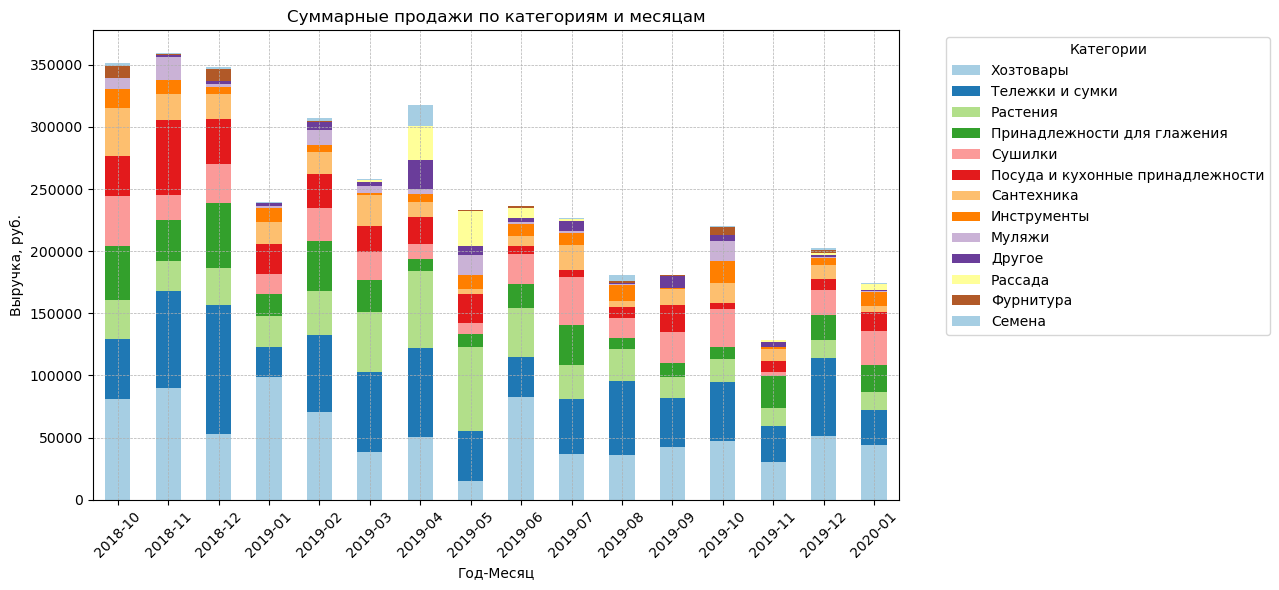

In [30]:
# Группировка по категории и году-месяцу, суммирование выручки
df_grouped = df.groupby(['year_month', 'category'])['revenue'].sum().unstack(fill_value=0)

# Подсчет суммарных продаж по категориям
category_sums = df_grouped.sum()

# Сортировка по убыванию суммарных продаж
category_sums_sorted = category_sums.sort_values(ascending=False)

# Переупорядочивание столбцов в исходных данных по отсортированному списку
df_grouped_sorted = df_grouped[category_sums_sorted.index]

# Создание стековой столбчатой диаграммы
fig, ax = plt.subplots(figsize=(13, 6))

# Использование палитры 'Paired'
colors = sns.color_palette('Paired', n_colors=len(df_grouped_sorted.columns))

# Построение графика
df_grouped_sorted.plot(kind='bar', stacked=True, ax=ax, color=colors)

# Добавление заголовка и меток осей
plt.title('Суммарные продажи по категориям и месяцам')
plt.xlabel('Год-Месяц')
plt.ylabel('Выручка, руб.')

# Поворот меток на оси x
plt.xticks(rotation=45)

# Добавление легенды вне графика
plt.legend(title='Категории', bbox_to_anchor=(1.05, 1), loc='upper left')

# Добавление сетки
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Отображение графика
plt.tight_layout()
plt.show()

- как я уже заметил выше, налицо общий спад продаж, давайте посмотрим на цифры месяц к месяцу, чтобы учесть сезонность. сопоставимы у нас только 4 месяца - октябрь-январь 2018-2019 и 2019-2020 

In [31]:
# Фильтрация для нужных месяцев
months_to_keep = ['2018-10', '2018-11', '2018-12', '2019-01', '2019-10', '2019-11', '2019-12', '2020-01']
df_filtered = df_grouped_sorted[df_grouped_sorted.index.isin(months_to_keep)]


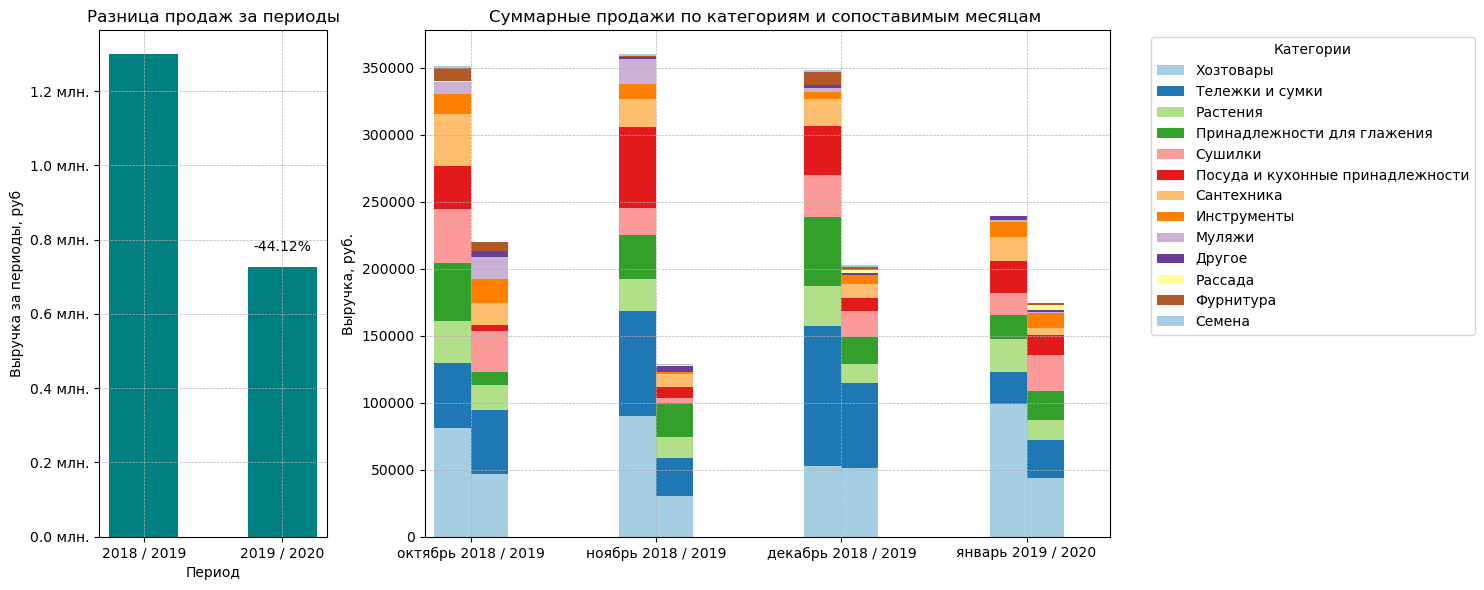

In [32]:
import matplotlib.ticker as ticker

# Создание стековой столбчатой диаграммы
fig, axes = plt.subplots(1, 2, figsize=(15, 6), width_ratios=[1,3])

# Использование палитры 'Paired'
colors = sns.color_palette('Paired', n_colors=len(df_filtered.columns))

# наборы месяцев
set1 = ['2018-10','2018-11','2018-12', '2019-01']
set2 = ['2019-10','2019-11','2019-12', '2020-01']

bar_width = 0.2  # Ширина столбцов

# посчитаем общие продажи по всем группам за 2 периода и подготовим данные для графика
total_set1 = df_filtered.loc[set1].sum().sum() #
total_set2 = df_filtered.loc[set2].sum().sum()
x = ['2018 / 2019', '2019 / 2020']
y = [total_set1, total_set2]

# Построение первого столбчатого графика на первом подграфике
axes[0].bar(x, y, color='teal', width=0.5)
axes[0].set_title('Разница продаж за периоды')
axes[0].set_xlabel('Период')
axes[0].set_ylabel('Выручка за периоды, руб')

# Добавление процента над вторым столбцом
percentage_change = ((total_set2 - total_set1) / total_set1) * 100
axes[0].text(1, total_set2 + total_set2 * 0.05, f'{percentage_change:.2f}%', ha='center', va='bottom')

# Форматирование оси y на первом графике в миллионах
axes[0].yaxis.set_major_formatter(lambda x, pos: f'{x*1e-6:1.1f} млн.')

# Построение графика для первого сета (2018-2019)
df_filtered.loc[set1].plot(kind='bar', stacked=True, ax=axes[1], color=colors, width=bar_width, position=1)

# Построение графика для второго сета (2019-2020)
df_filtered.loc[set2].plot(kind='bar', stacked=True, ax=axes[1], color=colors, width=bar_width, position=0)

# Добавление заголовка и меток осей
axes[1].set_title('Суммарные продажи по категориям и сопоставимым месяцам ')
axes[1].set_xlabel('')
axes[1].set_ylabel('Выручка, руб.')

# Добавление сетки
axes[0].grid(True, which='both', linestyle='--', linewidth=0.5)

# Метки оси Х правого графика
axes[1].set_xticks(ticks=[0,1,2,3], labels=['октябрь 2018 / 2019', 'ноябрь 2018 / 2019', 'декабрь 2018 / 2019', 'январь 2019 / 2020'], rotation=0)

# Добавление легенды вне графика
plt.legend(df_filtered.columns, title='Категории', bbox_to_anchor=(1.05, 1), loc='upper left')

# Добавление сетки
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Отображение графика
plt.tight_layout()
plt.show()


- из сравнения продаж по месяцам видим уровень падения продаж, который произошел за год - падали все основные категории (хозтовары, тележки, растения и гладильные принадлежности). Похоже, дело не в какой-то конкретной категории, а в продажах в целом - за год они **упали на 44.12%**.

Посмотрим на динамику продаж категорий по дням недели и часам 

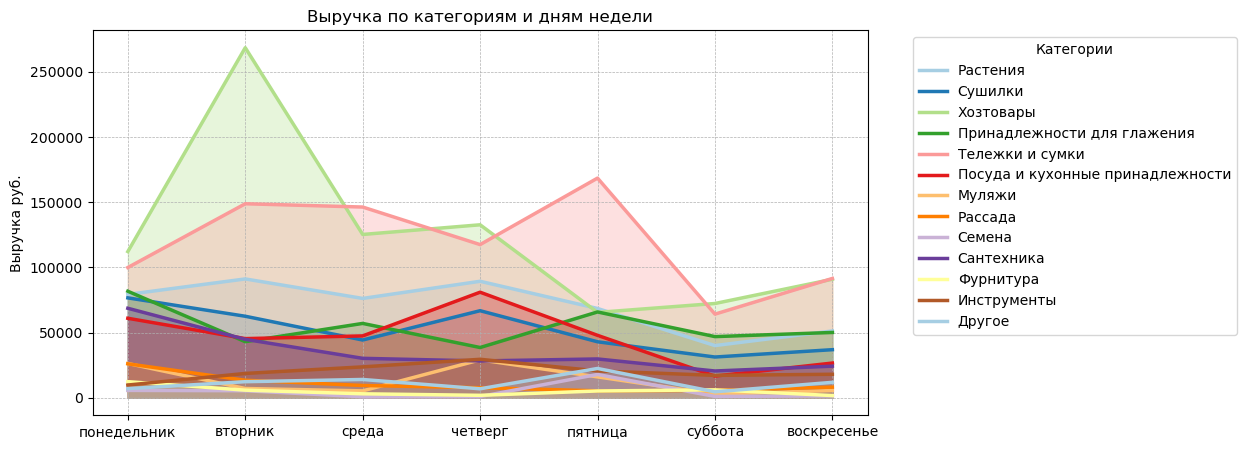

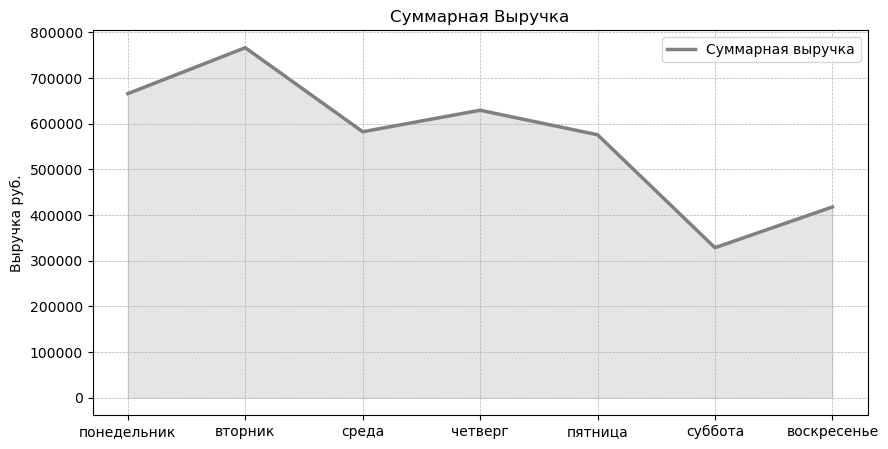

In [33]:
# Создание графика
plt.figure(figsize=(10, 5))

# Выбор цветов для линий
colors = sns.color_palette('Paired', n_colors=len(df['category'].unique()))

# Перебор категорий и построение графиков
for i, category in enumerate(df['category'].unique()):
    df_category = df.query('category == @category').groupby('weekday').agg(revenue=('revenue', 'sum')).sort_index()
    sns.lineplot(data=df_category, x=df_category.index, y='revenue', label=category, color=colors[i], linewidth=2.5)
    plt.fill_between(df_category.index, df_category['revenue'], alpha=0.3, color=colors[i])

# Установка заголовка и меток осей
plt.title('Выручка по категориям и дням недели')
plt.xlabel('')
plt.ylabel('Выручка руб.')
plt.xticks(ticks=[0,1,2,3,4,5,6], labels=['понедельник', 'вторник', 'среда', 'четверг', 'пятница', 'суббота', 'воскресенье'])

# Поворот меток на оси x
plt.xticks(rotation=0)

# Добавление сетки
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Добавление легенды и вынесение её за пределы графика справа
plt.legend(title='Категории', bbox_to_anchor=(1.05, 1), loc='upper left')

# Отображение графика
plt.show()

# Создание графика
plt.figure(figsize=(10, 5))

# Выбор цветов для линий
colors = sns.color_palette('Paired', n_colors=len(df['category'].unique()))

df_total = df.groupby('weekday').agg(total_revenue=('revenue', 'sum')).sort_index()
sns.lineplot(data=df_total, x=df_total.index, y='total_revenue', label='Суммарная выручка', color='grey', linewidth=2.5)
plt.fill_between(df_total.index, df_total['total_revenue'], alpha=0.1, color='black')

# Установка заголовка и меток осей
plt.title('Суммарная Выручка')
plt.xlabel('')
plt.ylabel('Выручка руб.')

plt.xticks(ticks=[0,1,2,3,4,5,6], labels=['понедельник', 'вторник', 'среда', 'четверг', 'пятница', 'суббота', 'воскресенье'])

# Поворот меток на оси x
plt.xticks(rotation=0)

# Добавление сетки
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

- из графика видим, что продажи в целом выше в будние дни, а в субботу-воскресенье - спад. Пик продаж по группам с наибольшими продажами (хозовары, тележки) приходится на вторник-среду. Тележки больше всего покупают в пятницу, видимо, перед поездками на выходных за покупками или на дачу. Хозтовары - во вторник: видимо, обнаружив в понедельник после работы отсутствие чего-то в доме, планируют поход в магазин на вторник Можно использовать эти наблюдения для целей маркетинга - **рассылки и спец. предложения на тележки в пятницу, например**.

Посмотрим, как распределены продажи по времени суток

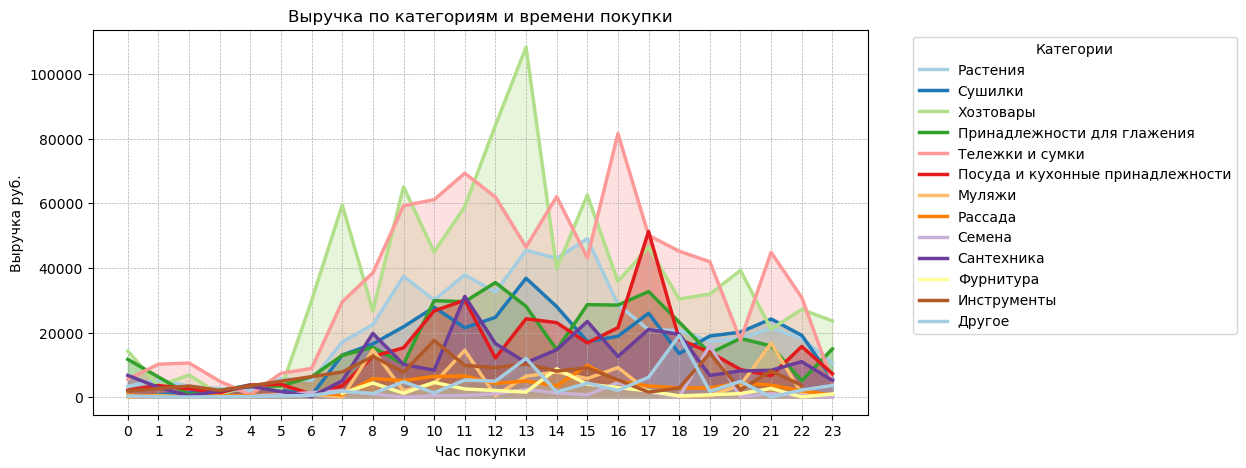

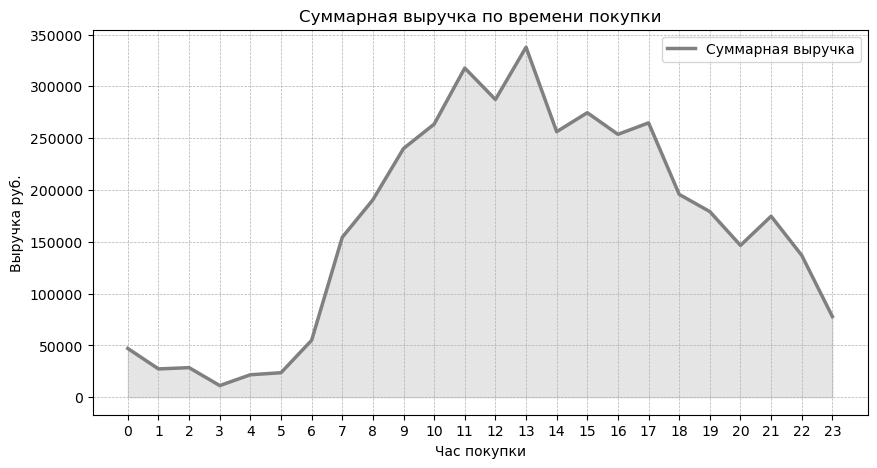

In [34]:
# Создание графика
plt.figure(figsize=(10, 5))

# Выбор цветов для линий
colors = sns.color_palette('Paired', n_colors=len(df['category'].unique()))

# Перебор категорий и построение графиков
for i, category in enumerate(df['category'].unique()):
    df_category = df.query('category == @category').groupby('hour').agg(revenue=('revenue', 'sum')).sort_index()
    sns.lineplot(data=df_category, x=df_category.index, y='revenue', label=category, color=colors[i], linewidth=2.5)
    plt.fill_between(df_category.index, df_category['revenue'], alpha=0.3, color=colors[i])

# Установка заголовка и меток осей
plt.title('Выручка по категориям и времени покупки')
plt.xlabel('Час покупки')
plt.ylabel('Выручка руб.')
plt.xticks(ticks=range(0, 24), labels= range(0, 24))

# Поворот меток на оси x
plt.xticks(rotation=0)

# Добавление сетки
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Добавление легенды и вынесение её за пределы графика справа
plt.legend(title='Категории', bbox_to_anchor=(1.05, 1), loc='upper left')

# Отображение графика
plt.show()

# Создание графика
plt.figure(figsize=(10, 5))

# Выбор цветов для линий
colors = sns.color_palette('Paired', n_colors=len(df['category'].unique()))

df_total = df.groupby('hour').agg(total_revenue=('revenue', 'sum')).sort_index()
sns.lineplot(data=df_total, x=df_total.index, y='total_revenue', label='Суммарная выручка', color='grey', linewidth=2.5)
plt.fill_between(df_total.index, df_total['total_revenue'], alpha=0.1, color='black')

# Установка заголовка и меток осей
plt.title('Суммарная выручка по времени покупки')
plt.xlabel('Час покупки')
plt.ylabel('Выручка руб.')

plt.xticks(ticks=range(0, 24), labels= range(0, 24))

# Поворот меток на оси x
plt.xticks(rotation=0)

# Добавление сетки
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

- из графиков становится понятно, что ночью продаж почти нет, начиная с 6 утра мы видим, как потребительская активность растет и достигает **пика в 11-13 часов.** На высоком уровне сохраняется до 18 часов (видимо, покупатели размещают заказы с работы), 17-20 часов спад (клиенты едут домой с работы и делают свои домашние дела), далее небольшой всплеск заказов в 21 часов - и далее все готовятся ко сну. **Можно использовать пик на 11-13 часов и делать рассылку с предложениями прямо перед этим.**

Перейдем с анализу данных по заказам и клиентам - посмотрим на распределения

In [35]:
# подготовим таблицу с данными по заказам
df_orders = df.groupby('order_id').agg(order_sum=('revenue', 'sum'), products_qty=('quantity','sum')).sort_values(by='order_sum', ascending=False).reset_index()
df_orders['avg_check'] = df_orders['order_sum'] / df_orders['products_qty']

# подготовим таблицу с данными по клиентам
df_customers = df.groupby('customer_id').agg(order_sum=('revenue', 'sum'), order_qty=('order_id','nunique')).sort_values(by='order_sum', ascending=False).reset_index()
df_customers['avg_check'] = df_customers['order_sum'] / df_customers['order_qty']

- ознакомимся с данными по клиентам

Статистика по клиентам

            order_sum    order_qty     avg_check
count    2450.000000  2450.000000   2450.000000
mean     1618.724252     1.450204   1168.838162
std      4309.941115     2.678379   2096.326319
min        15.000000     1.000000     15.000000
25%       391.500000     1.000000    300.000000
50%       838.000000     1.000000    648.000000
75%      1798.000000     2.000000   1346.750000
max    159508.000000   126.000000  49432.000000


У нас 2450 клиентов, совершивших покупки на сумму от 15.0 руб. и заканчивая 159508.0 р.


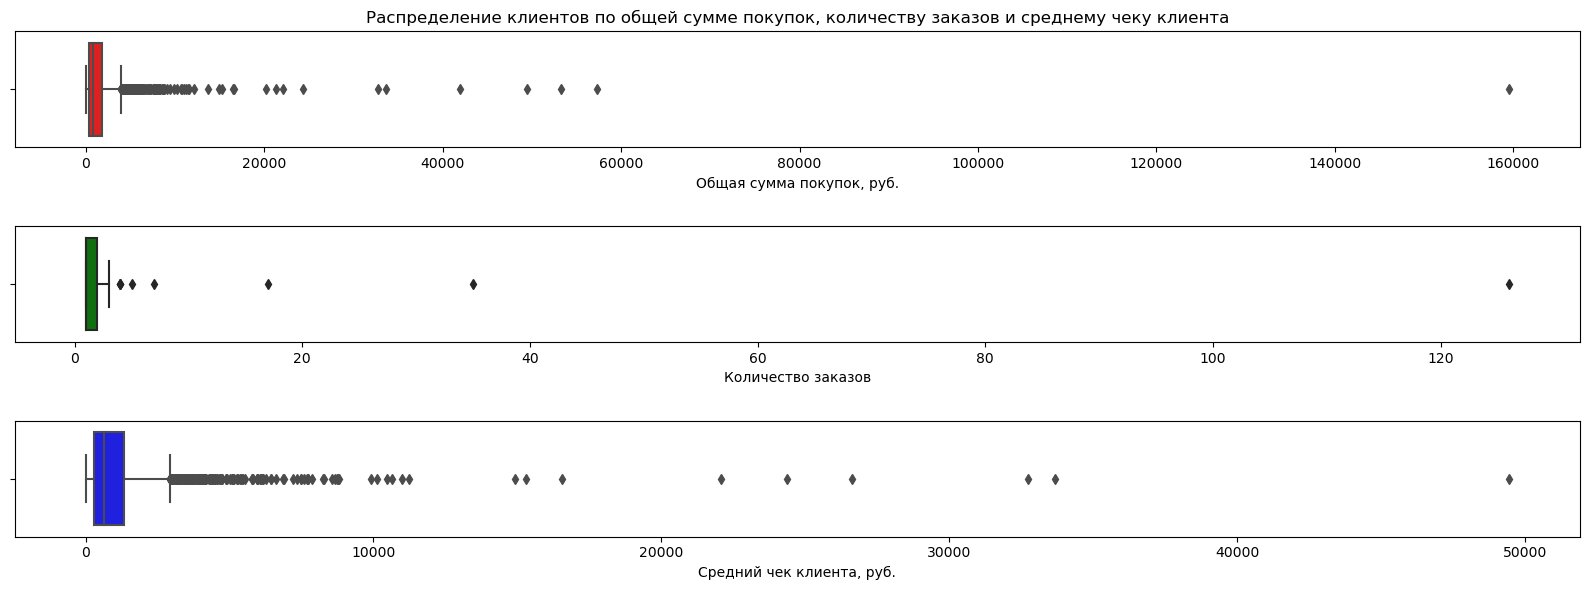

In [36]:
print('Статистика по клиентам\n\n', df_customers[['order_sum','order_qty','avg_check']].describe())

print('\n\nУ нас {} клиентов, совершивших покупки на сумму от {} руб. и заканчивая {} р.'.format(df_customers.shape[0], df_customers['order_sum'].min(), df_customers['order_sum'].max()))

# Создание фигуры и подграфиков
fig, axes = plt.subplots(3, 1, figsize=(16, 6))

# График для общей суммы заказов
sns.boxplot(data=df_customers, x='order_sum', color='red', ax=axes[0])
axes[0].set_title('Распределение клиентов по общей сумме покупок, количеству заказов и среднему чеку клиента')
axes[0].set_xlabel('Общая сумма покупок, руб.')

# График для количества заказов
sns.boxplot(data=df_customers, x='order_qty', color='green', ax=axes[1])
axes[1].set_title(' ')
axes[1].set_xlabel('Количество заказов')

# График для среднего чека
sns.boxplot(data=df_customers, x='avg_check', color='blue', ax=axes[2])
axes[2].set_title(' ')
axes[2].set_xlabel('Средний чек клиента, руб.')

# Регулировка расположения графиков и отображение
plt.tight_layout()
plt.show()


- 75% наших покупателей совершила покупки на сумму **не более 1798 р**., основная масса (95%) покупает на сумму **до 5000 р.** и только единицы превышают отметку в 10000 р., что дает основание утверждать, что наш **магазин работает в основном с розничными покупателями**. Медиана покупок клиентов - **838 р.**
- Анализ количества заказов на клиента говорит о том же - **1-2 заказа делают 75% клиентов.** Розница чистой воды, корпоративные и оптовые покупки характеризуются большей повторяемостью.
- Средний чек *(общая сумма покупок / количество заказов)* для **75% клиентов не превышает 1346 р**. Медиана - **648 руб.** Для улучшения ситуации с продажами, которые, как мы ранее видели, падают, нам **следует предпринять меры для увеличения среднего чека и количества повторных заказов**.

- теперь перейдем к заказам

Статистика по заказам

           order_sum  products_qty     avg_check
count   3520.000000   3520.000000   3520.000000
mean    1126.668868      3.853977    746.785954
std     2088.489576     13.356129   1153.517576
min        9.000000      1.000000      9.000000
25%      194.000000      1.000000    119.000000
50%      584.000000      1.000000    274.205882
75%     1274.000000      2.000000    899.000000
max    49432.000000    334.000000  14917.000000


У нас 3520 заказов на суммы от 9.0 руб. и заканчивая 49432.0 р.


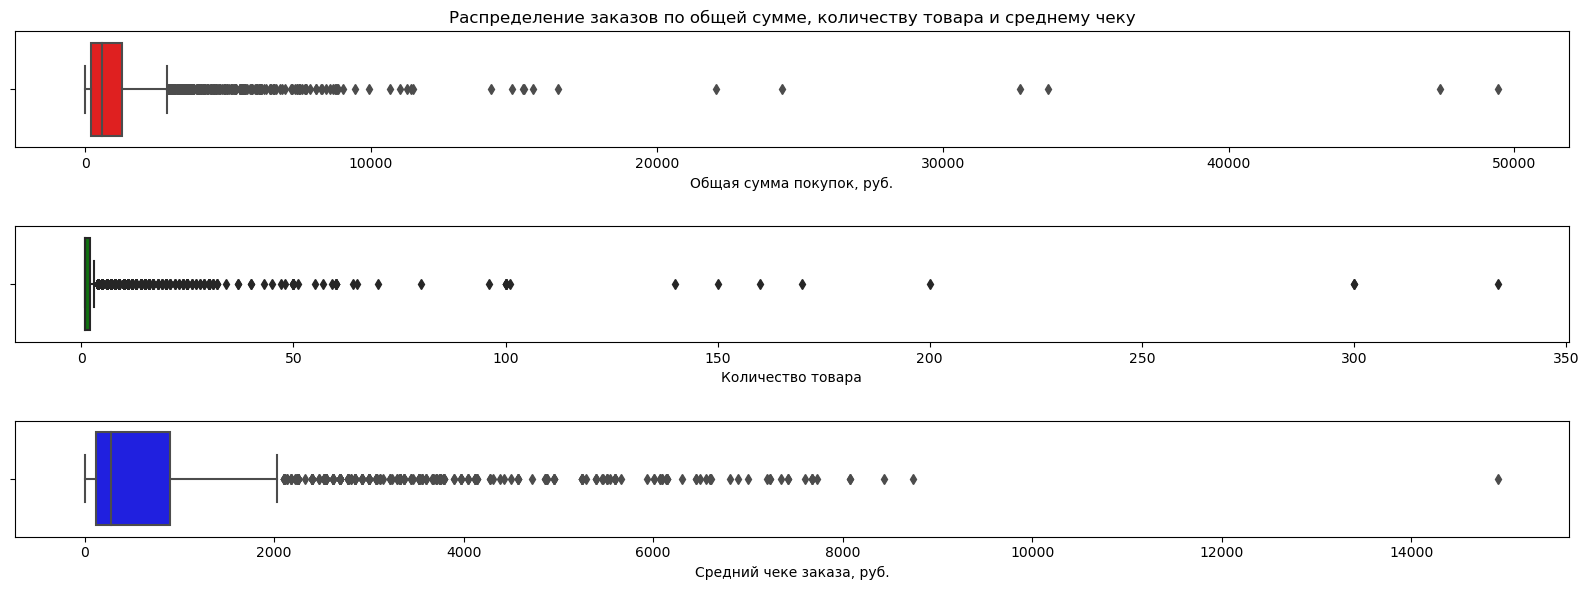

In [37]:
print('Статистика по заказам\n\n', df_orders[['order_sum','products_qty','avg_check']].describe())

print('\n\nУ нас {} заказов на суммы от {} руб. и заканчивая {} р.'.format(df_orders.shape[0], df_orders['order_sum'].min(), df_orders['order_sum'].max()))

# Создание фигуры и подграфиков
fig, axes = plt.subplots(3, 1, figsize=(16, 6))

# График для общей суммы заказов
sns.boxplot(data=df_orders, x='order_sum', color='red', ax=axes[0])
axes[0].set_title('Распределение заказов по общей сумме, количеству товара и среднему чеку')
axes[0].set_xlabel('Общая сумма покупок, руб.')

# График для количества товаров в заказе
sns.boxplot(data=df_orders, x='products_qty', color='green', ax=axes[1])
axes[1].set_title(' ')
axes[1].set_xlabel('Количество товара')

# График для среднего чека
sns.boxplot(data=df_orders, x='avg_check', color='blue', ax=axes[2])
axes[2].set_title(' ')
axes[2].set_xlabel('Средний чеке заказа, руб.')

# Регулировка расположения графиков и отображение
plt.tight_layout()
plt.show()


- видим, что **75% сумм заказов находятся в пределах 1274 р.,** достаточно много выбросов в промежутке **1274 - 10 000 р.** Заказы свыше 10 000 р. единичны. **Медианная сумма заказа = 584 р.**
- с количествами товаров в заказе еще проще -  **75% заказов находятся в пределах 2 единиц товаров,**. **Медиана - 1 шт.**. Заказы с количеством товаров выше 50 шт. единичны
- средний чек **75%** заказов лежит в диапазоне **9 - 899 р.** 95% заказов - **не выше 2000 р**. Медиана - **274 р.**


### Исследовательский анализ данных: выводы
- мы исследовали данные продаж по категориям, периоду, дням недели и времени дня, определили количество уникальных клиентов и заказов и посмотрели на их распределение, разбили товары на 13 категорий, среди которых крупнейшей по количеству уникальных названий является "Растения" (27.7% от всех уникальных названий товаров) . Ниже основные наблюдения и выводы:
1. Количество записей в нашей базе сократилось на 25% - с 7474 до 5590 - после того как мы обнаружили и удалили неполные дубликаты записей в рамках счетов. Коллегам следует обратить внимание на этот момент и найти причину появления дубликатов.
2. Период данных в нашем распоряжении - октябрь 2018 - январь 2020, неполные года, поэтому мы можем сравнивать YoY данные только за 4 сопоставимых месяца - октябрь-январь.
3. В количествах покупаемых товаров в 1 заказе достаточно много выбросов, учитывая то, что обычно количество не превышает 2 шт. чего-либо, но удалили мы только 1 запись - 1000 шт. вантузов. Остальные выбросы имеет смысл обсудить с коллегами и получить подтверждение их "нормальности"
4. 2 главные группы по выручке - `Хозтовары` и  `Тележки и сумки`. **Растения** растут в продажах к сезону - апрелю/маю, далее начинается спад. Следует поддерживать сезонный спрос на растения маркетингом. Также  можно отметить общий спад продаж - на 44.12% YoY. Падают все группы, значит, есть системная проблема в продажах.
5. В целом, продажи больше в будни, на выходных спад. Хозтовары лучше всего продаются во вторник, за тележками идут в пятницу. Это также нужно использовать для увеличения продаж с помощью маркетинга.
6. По времени - пик продаж приходится на 13 часов, что ярко просматривается у категории Хозтовары, например. Начиная с 22 и до 6 утра продажи "спят" 
7. Основная масса клиентов (95%) сделала 1-3 заказа и купила за весь период наблюдения на сумму **до 5000 р.**т, медиана покупок клиентов - **838 р**., средний чек *(общая сумма покупок / количество заказов)* для 75% клиентов не превышает **1346 р.** Медиана - **648 руб**. Для улучшения ситуации с продажами, которые, как мы ранее видели, падают, нам **следует предпринять меры для увеличения среднего чека и количества повторных заказов**.
8. Медианная сумма заказа = **584 р.**, а 75% сумм заказов находятся в пределах **1274 р**. и содержат **1-2 единицы товаров**.


## АВС-анализ продуктов

### Разделение продуктов на критерии ABC по продажам в шт.

Теперь перейдем к ABC анализу - определению наиболее важных продуктов для бизнеса

ABC-анализ — это метод классификации товаров в магазине по их значимости для бизнеса. Он помогает определить, какие товары имеют наибольшее влияние на общую прибыль и требуют более внимательного управления запасами. В ходе ABC-анализа товары делятся на три категории:

A-категория: товары с наибольшей значимостью. Обычно это 20% товаров, которые приносят 70-80% выручки.
B-категория: товары средней значимости. Это примерно 30% товаров, которые приносят 15-25% выручки.
C-категория: товары наименее значимые. Это около 50% товаров, которые приносят 5-10% выручки.

**Принципы ABC-анализа**<br><hr>
- Сбор данных о продажах: сбор данных о выручке или количестве продаж для каждого товара за определенный период.<br>
- Расчет общего дохода или количества продаж для каждого товара.<br>
- Сортировка товаров по убыванию их вклада в общий доход или продажи.<br>
- Расчет кумулятивного процента вклада каждого товара в общий доход.<br>
- Классификация товаров на категории A, B и C на основе кумулятивных процентов.<br>


In [38]:
# функция для присвоения категории ABC
def abc_classify_product(percentage):
 
    if percentage > 0 and percentage <= 80:
        return 'A'
    elif percentage > 80 and percentage <= 90:
        return 'B'
    else:
        return 'C'

In [39]:
products_qty = (
    df.groupby('product')
    .agg(total_qty=('quantity','sum'))
    .sort_values(by='total_qty', ascending=False)   
    .reset_index() 
)

display(products_qty)

,product,total_qty
0,Муляж ЯБЛОКО 9 см красное,618
1,Вешалки мягкие для деликатных вещей 3 шт шоколад,335
2,Муляж Яблоко зеленый 9 см полиуретан,308
3,"Ручка-скоба РС-100 белая *Трибатрон*, 1108035",201
4,"Крепеж для пружины дверной, 1107055",170
...,...,...
2337,Литопс Микс d-5 см,1
2338,Сумка-тележка GIMI Easy Go красная,1
2339,"Лестница-стремянка Примус оцинкованный металл 7 ступеней, 1,55 м , 1203048",1
2340,"Сумка-тележка хозяйственная Andersen Alu Star Shopper, Hava, синяя 115-103-90",1


In [40]:
# добавим cumsum и % от общего
products_qty['cum_sum'] = products_qty['total_qty'].cumsum(axis=0)
products_qty['perc_from_total'] = products_qty['cum_sum'] / products_qty['total_qty'].sum() * 100

display(products_qty.head(10))

,product,total_qty,cum_sum,perc_from_total
0,Муляж ЯБЛОКО 9 см красное,618,618,4.555506
1,Вешалки мягкие для деликатных вещей 3 шт шоколад,335,953,7.024915
2,Муляж Яблоко зеленый 9 см полиуретан,308,1261,9.295297
3,"Ручка-скоба РС-100 белая *Трибатрон*, 1108035",201,1462,10.776942
4,"Крепеж для пружины дверной, 1107055",170,1632,12.030075
5,Плечики пластмассовые Размер 52 - 54 Тула 1205158,160,1792,13.209494
6,"Пружина дверная 240 мм оцинкованная (Д-19 мм) без крепления, 1107014",150,1942,14.315200
7,Муляж Банан желтый 21 см полиуретан,109,2051,15.118679
8,"Щетка-сметка 4-х рядная деревянная 300 мм (фигурная ручка) ворс 5,5 см 1801096",105,2156,15.892673
9,"Ёрш унитазный с деревянной ручкой , Ваир 1712012",103,2259,16.651924


In [41]:
# присваиваем категории 
products_qty['abc_class_qty'] = products_qty['perc_from_total'].apply(abc_classify_product)

# Сортировка по total_revenue для наглядности
products_qty_sorted = products_qty.sort_values(by=['abc_class_qty', 'total_qty'], ascending=[True, False])

# Вывод DataFrame
display(products_qty_sorted)



,product,total_qty,cum_sum,perc_from_total,abc_class_qty
0,Муляж ЯБЛОКО 9 см красное,618,618,4.555506,A
1,Вешалки мягкие для деликатных вещей 3 шт шоколад,335,953,7.024915,A
2,Муляж Яблоко зеленый 9 см полиуретан,308,1261,9.295297,A
3,"Ручка-скоба РС-100 белая *Трибатрон*, 1108035",201,1462,10.776942,A
4,"Крепеж для пружины дверной, 1107055",170,1632,12.030075,A
...,...,...,...,...,...
2337,Литопс Микс d-5 см,1,13562,99.970515,C
2338,Сумка-тележка GIMI Easy Go красная,1,13563,99.977886,C
2339,"Лестница-стремянка Примус оцинкованный металл 7 ступеней, 1,55 м , 1203048",1,13564,99.985257,C
2340,"Сумка-тележка хозяйственная Andersen Alu Star Shopper, Hava, синяя 115-103-90",1,13565,99.992629,C


Посмотрим на числовые статистики по классам

In [42]:
df_abc_qty = products_qty_sorted.groupby('abc_class_qty').agg(
    total_skus=('product', 'nunique'),
       total_qty=('total_qty', 'sum')
).reset_index()

df_abc_qty.head()

,abc_class_qty,total_skus,total_qty
0,A,699,10851
1,B,517,1357
2,C,1126,1358


### Разделение продуктов на критерии ABC по продажам в руб.

In [43]:
products_revenue = (
    df.groupby('product')
    .agg(total_revenue=('revenue','sum'))
    .sort_values(by='total_revenue', ascending=False)   
    .reset_index() 
)

display(products_revenue)

,product,total_revenue
0,Простынь вафельная 200х180 см WELLNESS RW180-01 100% хлопок,53232.0
1,Сумка-тележка 2-х колесная Gimi Argo синяя,50405.0
2,Вешалки мягкие для деликатных вещей 3 шт шоколад,49596.0
3,Тележка багажная DELTA ТБР-22 синий грузоподъемность 20 кг сумка и 50 кг каркас РОССИЯ,33992.0
4,Муляж ЯБЛОКО 9 см красное,32702.0
...,...,...
2337,"Цинния Коралловая красавица 0,2 г 4660010773323",10.0
2338,Петрушка Итальянский гигант 2 г 4660010776553,10.0
2339,Морковь Детская сладость 2 г 4660010775921,10.0
2340,"Цинния Оранжевый король 0,5 г 4660010770520",10.0


In [44]:
# добавим cumsum и % от общего
products_revenue['cum_sum'] = products_revenue['total_revenue'].cumsum(axis=0)
products_revenue['perc_from_total'] = products_revenue['cum_sum'] / products_revenue['total_revenue'].sum() * 100

display(products_revenue.head(10))

,product,total_revenue,cum_sum,perc_from_total
0,Простынь вафельная 200х180 см WELLNESS RW180-01 100% хлопок,53232.0,53232.0,1.342251
1,Сумка-тележка 2-х колесная Gimi Argo синяя,50405.0,103637.0,2.613219
2,Вешалки мягкие для деликатных вещей 3 шт шоколад,49596.0,153233.0,3.863789
3,Тележка багажная DELTA ТБР-22 синий грузоподъемность 20 кг сумка и 50 кг каркас РОССИЯ,33992.0,187225.0,4.720901
4,Муляж ЯБЛОКО 9 см красное,32702.0,219927.0,5.545486
5,Набор ножей Attribute CHEF 5 предметов AKF522,29248.0,249175.0,6.282978
6,"Сумка-тележка хозяйственная Andersen Scala Shopper Plus, Lini, синяя 133-108-90",28045.0,277220.0,6.990136
7,Сушилка Meliconi Stendy Junior,27970.0,305190.0,7.695403
8,Мусорный контейнер Hailo BigBin Swing 45 0845-010 45 л хром,27560.0,332750.0,8.390331
9,"Урна уличная ""Гео"", Hobbyka/Хоббика, 59*37,5см, сталь",24370.0,357120.0,9.004824


In [45]:
# присваиваем категории 
products_revenue['abc_class_revenue'] = products_revenue['perc_from_total'].apply(abc_classify_product)

# Сортировка по total_revenue для наглядности
products_revenue_sorted = products_revenue.sort_values(by=['abc_class_revenue', 'total_revenue'], ascending=[True, False])

# Вывод DataFrame
display(products_revenue_sorted)

,product,total_revenue,cum_sum,perc_from_total,abc_class_revenue
0,Простынь вафельная 200х180 см WELLNESS RW180-01 100% хлопок,53232.0,5.323200e+04,1.342251,A
1,Сумка-тележка 2-х колесная Gimi Argo синяя,50405.0,1.036370e+05,2.613219,A
2,Вешалки мягкие для деликатных вещей 3 шт шоколад,49596.0,1.532330e+05,3.863789,A
3,Тележка багажная DELTA ТБР-22 синий грузоподъемность 20 кг сумка и 50 кг каркас РОССИЯ,33992.0,1.872250e+05,4.720901,A
4,Муляж ЯБЛОКО 9 см красное,32702.0,2.199270e+05,5.545486,A
...,...,...,...,...,...
2337,"Цинния Коралловая красавица 0,2 г 4660010773323",10.0,3.965835e+06,99.999017,C
2338,Петрушка Итальянский гигант 2 г 4660010776553,10.0,3.965845e+06,99.999269,C
2339,Морковь Детская сладость 2 г 4660010775921,10.0,3.965855e+06,99.999521,C
2340,"Цинния Оранжевый король 0,5 г 4660010770520",10.0,3.965865e+06,99.999773,C


Посмотрим на числовые статистики по классам

In [46]:
df_abc = products_revenue_sorted.groupby('abc_class_revenue').agg(
    total_skus=('product', 'nunique'),
       total_revenue=('total_revenue', 'sum')
).reset_index()

total_products = df_abc['total_skus'].sum()
df_abc['perc'] = df_abc['total_skus'] / total_products * 100
df_abc.head()

,abc_class_revenue,total_skus,total_revenue,perc
0,A,629,3.171730e+06,26.857387
1,B,365,3.974337e+05,15.584970
2,C,1348,3.967110e+05,57.557643


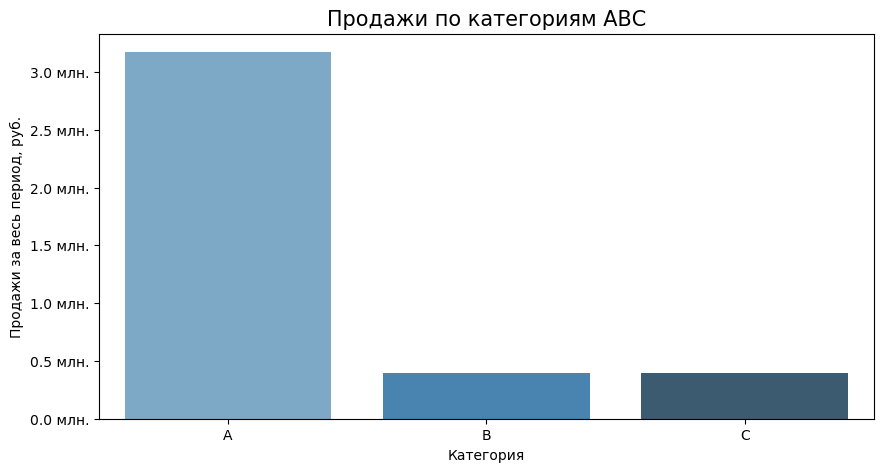

In [47]:
plt.figure(figsize=(10, 5))
sns.barplot(x="abc_class_revenue", 
            y="total_revenue", 
            data=df_abc,
            palette="Blues_d")\
            .set_title("Продажи по категориям АВС", fontsize=15)

# Форматирование оси y на графике в миллионах
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x*1e-6:1.1f} млн.'))
plt.xlabel('Категория')
plt.ylabel('Продажи за весь период, руб.')

plt.show()

- количество продуктов, попадающих в категорию А и делающих 80% оборота составляет почти 27% от их общего количества. Это говорит о сравнительно равномерном распределении продаж, нет ярко выраженных продуктов-лидеров. 

### Объединение получившихся критериев в новое поле: определение основного и дополнительного ассортимента

- теперь объединим получившиеся данные категорий и рангов: с основной таблице создадим колонку ABC и колонку Rank - каждому продукту пропишем комбинацию из категории в шт и руб. и ранг среди его категории, отдельно в руб. и шт. Например, ВА - это значит товар попал в категорию В в шт, но п деньгах -  в А.

In [48]:
products_ABC_ranks = products_qty_sorted.merge(products_revenue_sorted, how='inner', left_on='product', right_on='product')
display(products_ABC_ranks.head())

,product,total_qty,cum_sum_x,perc_from_total_x,abc_class_qty,total_revenue,cum_sum_y,perc_from_total_y,abc_class_revenue
0,Муляж ЯБЛОКО 9 см красное,618,618,4.555506,A,32702.0,2.199270e+05,5.545486,A
1,Вешалки мягкие для деликатных вещей 3 шт шоколад,335,953,7.024915,A,49596.0,1.532330e+05,3.863789,A
2,Муляж Яблоко зеленый 9 см полиуретан,308,1261,9.295297,A,17572.0,5.686870e+05,14.339511,A
3,"Ручка-скоба РС-100 белая *Трибатрон*, 1108035",201,1462,10.776942,A,5829.0,1.800562e+06,45.401385,A
4,"Крепеж для пружины дверной, 1107055",170,1632,12.030075,A,3290.0,2.473196e+06,62.361928,A


Объединим данные категорий в одно поле, посчитаем ранги и удалим все лишнее.

In [49]:
products_ABC_ranks['abc_qty_revenue'] = products_ABC_ranks['abc_class_qty']+products_ABC_ranks['abc_class_revenue']

products_ABC_ranks['rank_revenue'] = products_ABC_ranks.groupby('abc_qty_revenue')['total_revenue'].rank(ascending=False, method='first').astype(int)
products_ABC_ranks['rank_qty'] = products_ABC_ranks.groupby('abc_qty_revenue')['total_qty'].rank(ascending=False, method='first').astype(int)

products_ABC_ranks.drop(columns=['total_qty', 'cum_sum_x', 'perc_from_total_x',	'abc_class_qty','total_revenue','cum_sum_y','perc_from_total_y','abc_class_revenue'], inplace=True)

display(products_ABC_ranks)

,product,abc_qty_revenue,rank_revenue,rank_qty
0,Муляж ЯБЛОКО 9 см красное,AA,5,1
1,Вешалки мягкие для деликатных вещей 3 шт шоколад,AA,3,2
2,Муляж Яблоко зеленый 9 см полиуретан,AA,18,3
3,"Ручка-скоба РС-100 белая *Трибатрон*, 1108035",AA,88,4
4,"Крепеж для пружины дверной, 1107055",AA,152,5
...,...,...,...,...
2337,Литопс Микс d-5 см,CC,564,779
2338,Сумка-тележка GIMI Easy Go красная,CA,179,191
2339,"Лестница-стремянка Примус оцинкованный металл 7 ступеней, 1,55 м , 1203048",CA,161,192
2340,"Сумка-тележка хозяйственная Andersen Alu Star Shopper, Hava, синяя 115-103-90",CA,7,193


- теперь для вывода ТОП-5 продуктов по продажам в руб. из категории АА (т.е. самой интересной для продаж), можно написать так:
 

In [50]:
display(products_ABC_ranks.query('abc_qty_revenue == "AA" & rank_revenue<=5'))

,product,abc_qty_revenue,rank_revenue,rank_qty
0,Муляж ЯБЛОКО 9 см красное,AA,5,1
1,Вешалки мягкие для деликатных вещей 3 шт шоколад,AA,3,2
34,Тележка багажная DELTA ТБР-22 синий грузоподъемность 20 кг сумка и 50 кг каркас РОССИЯ,AA,4,33
44,Сумка-тележка 2-х колесная Gimi Argo синяя,AA,2,40
63,Простынь вафельная 200х180 см WELLNESS RW180-01 100% хлопок,AA,1,54


- а для вывода 10 самых-самых отстающих продуктов по продажам в руб., можно написать так:
 

In [51]:
display(products_ABC_ranks.query('abc_qty_revenue == "CC"').sort_values(by='rank_revenue', ascending=False).head(10))

,product,abc_qty_revenue,rank_revenue,rank_qty
1664,"Горох Амброзия 10,0 г 4660010772616",CC,780,310
2233,Морковь Детская сладость 2 г 4660010775921,CC,779,719
2085,Петрушка Итальянский гигант 2 г 4660010776553,CC,778,634
1859,"Огурец Засолочный 0,3 г 4660010776102",CC,777,445
1781,"Цинния Оранжевый король 0,5 г 4660010770520",CC,776,392
1780,"Цинния Коралловая красавица 0,2 г 4660010773323",CC,775,391
2289,"Лаватера Монт Блан 0,3 г 4660010778588",CC,774,754
2148,"Космея Кэнди страйп 0,3 г 4650091480272",CC,773,666
1543,"Капуста декоративная смесь 0,1 г 4650091480234",CC,772,223
1523,"Календула Пинк сюрпрайз 0,5 г 4650091480203",CC,771,207


Присвоим соответствующие значения из таблицы продуктам в таблице с продажами

In [52]:
# C этим справится отлично объединение таблиц методом merge c how=left
df = df.merge(products_ABC_ranks, how='left', left_on='product', right_on='product')
display(df.head())



,date,customer_id,order_id,product,quantity,price,year,month,year_month,weekday,hour,product_3_words,category,revenue,abc_qty_revenue,rank_revenue,rank_qty
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,2018,10,2018-10,0,0,комнатное растение горшке,Растения,142.0,AC,91,244
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194.0,2018,10,2018-10,0,0,комнатное растение горшке,Растения,194.0,CC,169,145
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,2018,10,2018-10,0,0,радермахера,Растения,112.0,CC,559,556
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,2018,10,2018-10,0,0,хризолидокарпус лутесценс,Растения,179.0,BC,135,233
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,2018,10,2018-10,0,0,циперус зумула,Растения,112.0,AA,125,43


### Анализ продаж продуктов в разрезе категорий и критериев ABC

- посмотрим теперь на продажи продуктов с учетом проведенной категоризации АВС



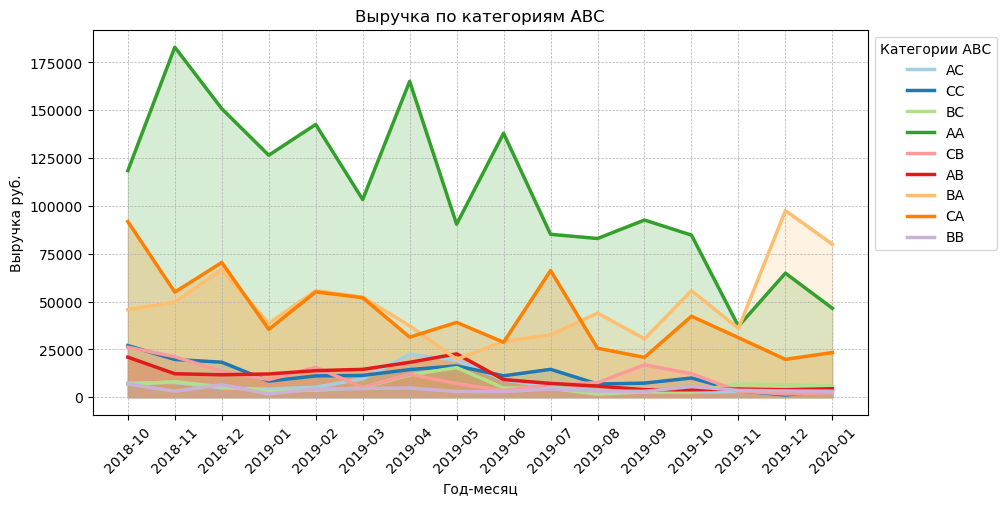

In [53]:
# готовим формат графика
plt.figure(figsize=(10,5))

# Выбор цветов для линий
colors = sns.color_palette('Paired', n_colors=len(df['abc_qty_revenue'].unique()))


for i, type in enumerate(df['abc_qty_revenue'].unique()):
    record = df.query('abc_qty_revenue == @type').groupby('year_month').agg(revenue=('revenue','sum'))
    sns.lineplot(record, x='year_month', y='revenue', legend='auto', label=type, color=colors[i], linewidth=2.5)
    plt.fill_between(record.index, record['revenue'], alpha=0.2, color=colors[i])

# Установка заголовка и меток осей
plt.title('Выручка по категориям АВС')
plt.xlabel('Год-месяц')
plt.ylabel('Выручка руб.')

# Поворот меток на оси x
plt.xticks(rotation=45)

# Добавление сетки
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Добавление легенды и вынесение её за пределы графика справа
plt.legend(title='Категории АВС', bbox_to_anchor=(1, 1), loc='upper left')

# Отображение графика
plt.show()

- первое, что бросается в глаза при взгляде на график - падение продаж категории АА - нашей ключевой группы товаров по продажам в шт и руб. и рост категории ВА - менее успешной по продажам в шт. Это может говорить о проблемах с поддержанием наличия на складе товаров АА и, как следствие, более частыми продажами группы ВА, либо о плохой ценовой политике в категории АА.

Давайте посмотрим на продажи ТОП-10 продуктов группы АА за весь период

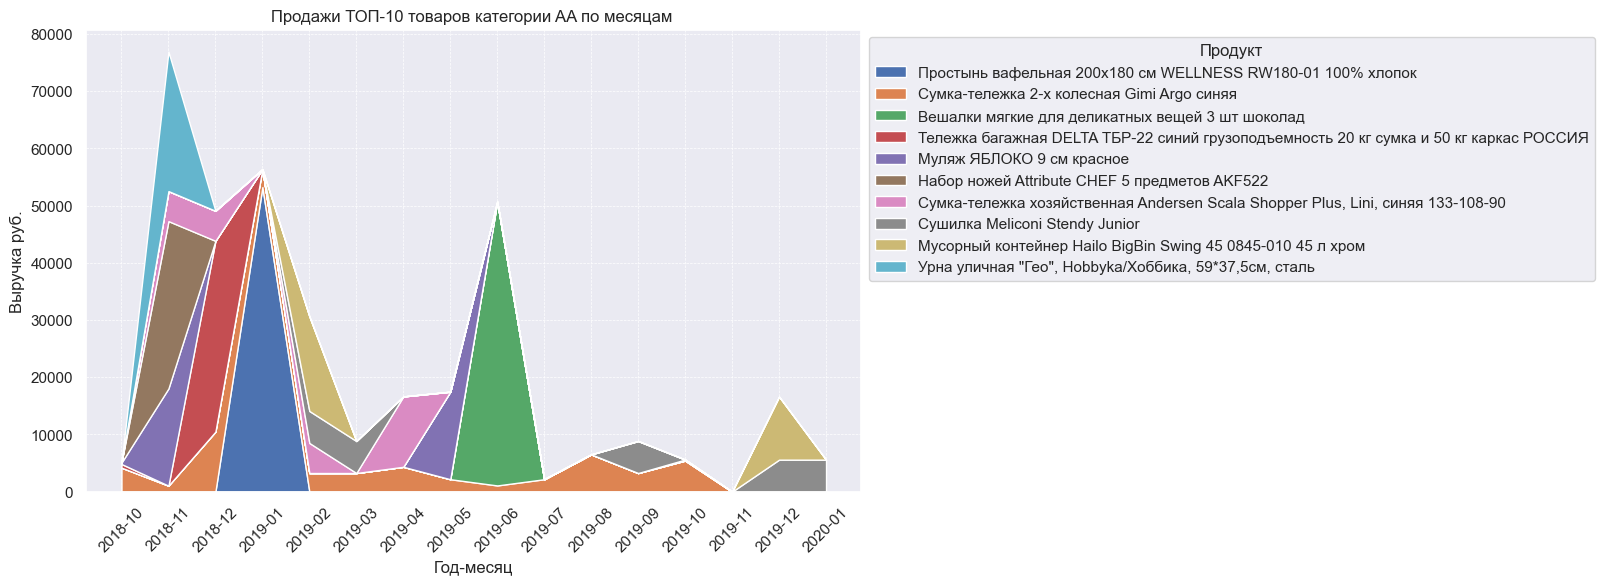

In [54]:
top10_aa = (
    df.query('abc_qty_revenue == "AA"')
    .groupby('product')
    .agg(revenue=('revenue','sum'))
    .sort_values(by='revenue', ascending=False).head(10)
)

# напишем функцию для построения stacked area plot
def stacked_area_plot(set, abc):
    sns.set_theme()
    plt.figure(figsize=(10,6)) 

    # подготовим данные для stacked are plot
    x=df['year_month'].unique()
    labels = set.index

    y_total = []
    for product in set.index:
        y_month = []
        for month in df['year_month'].unique():
            y=df.query('product==@product & year_month==@month')['revenue'].sum()
            y_month.append(y)
        y_total.append(y_month)

    plt.stackplot(x,y_total, labels=labels)

    # Установка заголовка и меток осей
    plt.title('Продажи ТОП-10 товаров категории {} по месяцам '.format(abc))
    plt.xlabel('Год-месяц')
    plt.ylabel('Выручка руб.')

    # Поворот меток на оси x
    plt.xticks(rotation=45)

    # Добавление сетки
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Добавление легенды и вынесение её за пределы графика справа
    plt.legend(title='Продукт', bbox_to_anchor=(1, 1), loc='upper left')

    # Отображение графика
    plt.show()

stacked_area_plot(top10_aa, 'AA')

- мы видим из графика, что продажи крайне неравномерны даже у продуктов из ТОП-10: до 2019-01 они складывались из продаж 3-5 наименований в месяц, а после 2019-01 сошли на нет - в продажах участвуют 1-2 товара. Это говорит либо о проблемах с поддержанием наличия, либо с плохим ценообразованием на ключевые товары. Например, в ноябре 2019 НИ ОДНО из наших ТОП-10 наименований не продавалось вообще.
- на графике видны пики продаж 2х продуктов - 2019-01 (простынь) и 2019-06 (вешалки). Давайте посмотрим, были ли это единичные заказы или это результат какой-то акции и заказов много.  

In [55]:
# Подстрока для поиска
substring1 = "RW180-01"
substring2 = "Вешалки мягкие"

filtered_df = df.query('product.str.contains(@substring1, case=False, na=False)', engine='python')
display(filtered_df)


filtered_df = df.query('product.str.contains(@substring2, case=False, na=False)', engine='python')
display(filtered_df)

,date,customer_id,order_id,product,quantity,price,year,month,year_month,weekday,hour,product_3_words,category,revenue,abc_qty_revenue,rank_revenue,rank_qty
1257,2019-01-10 13:00:00,58a4c3cc-504f-43ea-a74a-bae19e665552,69766,Простынь вафельная 200х180 см WELLNESS RW180-01 100% хлопок,3,1949.0,2019,1,2019-01,3,13,простынь вафельная х,Хозтовары,5847.0,AA,1,54
1295,2019-01-15 13:00:00,58a4c3cc-504f-43ea-a74a-bae19e665552,69830,Простынь вафельная 200х180 см WELLNESS RW180-01 100% хлопок,27,1755.0,2019,1,2019-01,1,13,простынь вафельная х,Хозтовары,47385.0,AA,1,54


,date,customer_id,order_id,product,quantity,price,year,month,year_month,weekday,hour,product_3_words,category,revenue,abc_qty_revenue,rank_revenue,rank_qty
741,2018-11-19 13:00:00,a22a06d8-ba39-4ee0-be74-84f471cd18a6,69050,Вешалки мягкие для деликатных вещей 3 шт желтые,4,164.0,2018,11,2018-11,0,13,вешалки мягкие деликатных,Хозтовары,656.0,AC,50,222
3739,2019-06-11 07:00:00,146cd9bf-a95c-4afb-915b-5f6684b17444,71668,Вешалки мягкие для деликатных вещей 3 шт шоколад,334,148.0,2019,6,2019-06,1,7,вешалки мягкие деликатных,Хозтовары,49432.0,AA,3,2
3768,2019-06-13 11:00:00,bc507650-4585-400d-874e-078d5bf3b36e,71694,Вешалки мягкие для деликатных вещей 3 шт шоколад,1,164.0,2019,6,2019-06,3,11,вешалки мягкие деликатных,Хозтовары,164.0,AA,3,2
4710,2019-10-10 14:00:00,2a8b22dd-1929-4c10-bbeb-b57953584d9d,72917,Вешалки мягкие для деликатных вещей 3 шт голубые,2,164.0,2019,10,2019-10,3,14,вешалки мягкие деликатных,Хозтовары,328.0,BC,51,40
5285,2019-12-28 23:00:00,1a2a1e41-fabc-454b-b279-c4346b29b71c,102579,Вешалки мягкие для деликатных вещей 3 шт голубые,1,164.0,2019,12,2019-12,5,23,вешалки мягкие деликатных,Хозтовары,164.0,BC,51,40


- в случае простыни, покупку совершил 1 клиент, 2 заказа на 3 и на 27 шт. Похоже на оптовую покупку, не результат акции.
- в случае вешалки - видим всего 1 покупку, но сразу на 334 вешалки шоколадного цвета. Другие вешалки тоже продавались 2019-06, но в единичных количествах. Вероятнее всего, если это не ошибочные данные о количестве - это оптовая покупка

Проведем аналогичный анализ продаж товаров группы ВА

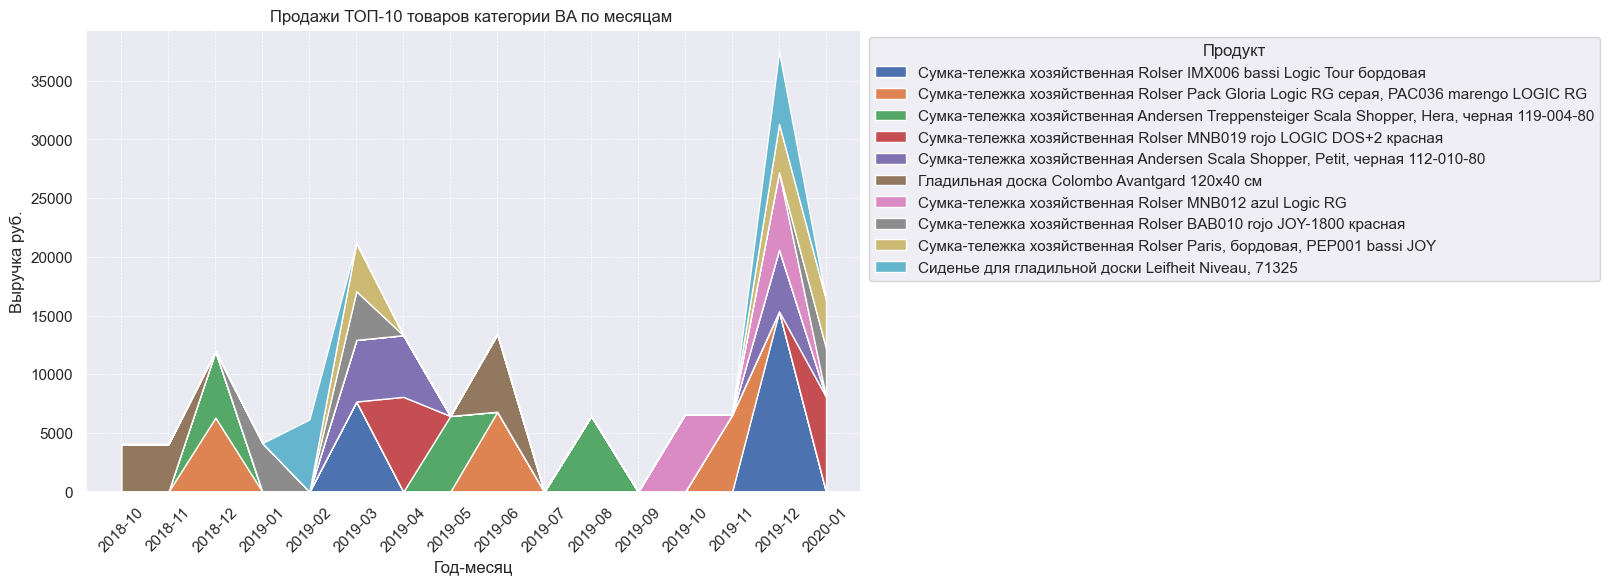

In [56]:
top10_ba = (
    df.query('abc_qty_revenue == "BA"')
    .groupby('product')
    .agg(revenue=('revenue','sum'))
    .sort_values(by='revenue', ascending=False).head(10)
)

stacked_area_plot(top10_ba, 'BA')

- на графике видим продажи сумок-тележек всех мастей. В декабре 2019 года - значительный рост продаж практически всех представленных в категории продуктов - явно результат какой-то акции, поскольку в другие месяцы продажи ограничивались 1-2 продуктами. Выяснить у маркетинга, что было сделано в декабре и масштабировать. 

Посмотрим теперь на продажи группы ВВ - можно ли выделить там растущие в продажах продукты и выводить их наверх в продажах?

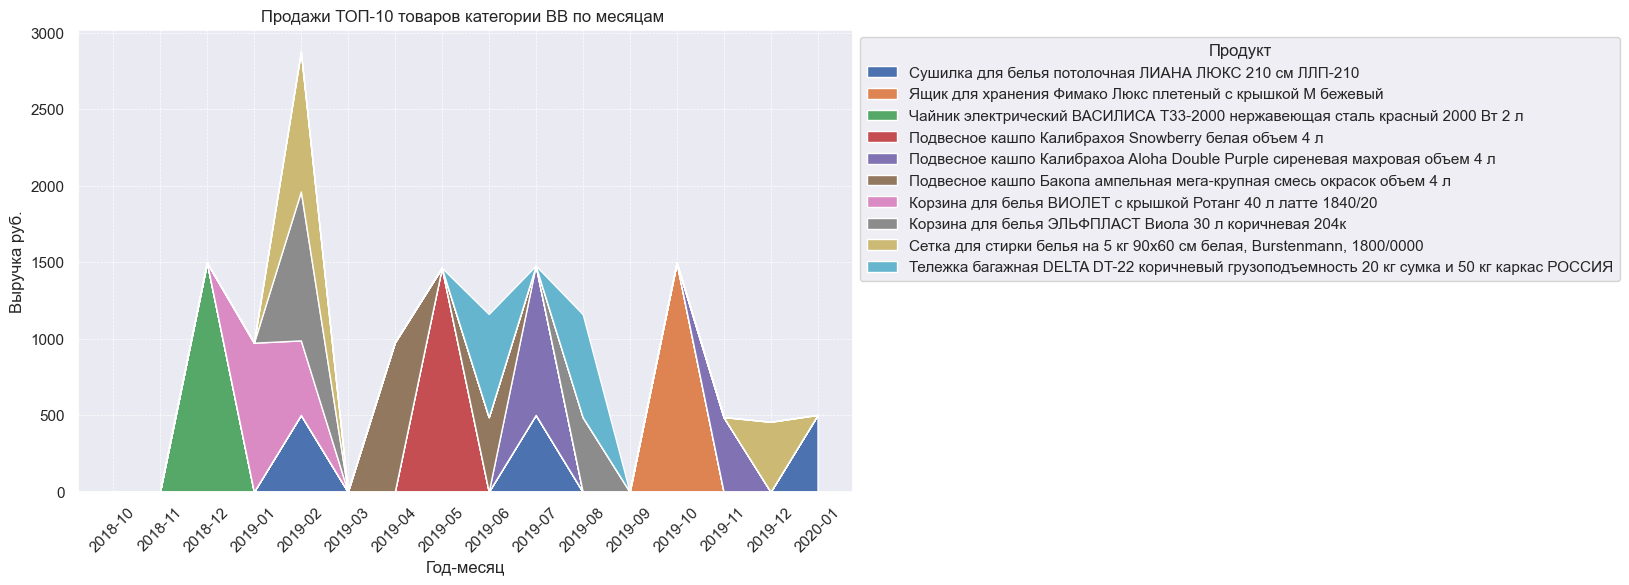

In [57]:
top10_bb = (
    df.query('abc_qty_revenue == "BB"')
    .groupby('product')
    .agg(revenue=('revenue','sum'))
    .sort_values(by='revenue', ascending=False).head(10)
)

stacked_area_plot(top10_bb, 'BB')

- мы видим, что продукты из категории ВВ не показывают устойчивого роста, продажи делают разные 1-2 продукта в месяц. Исключение составляют хозтовары в феврале 2019

 ### АВС-анализ продуктов: выводы

 - мы провели сегментацию наших продуктов на АВС категории по продажам:
    - в класс А по выручке попали 629 продуктов, что составило 27% от их общего количества
    - В - 365 продуктов
    - С - 1348 продуктов

То, что в классе А почти 30% товаров говорит о выраженной "размазанности" продаж: товары из группы А недостаточно популярны, мало явных лидеров, поэтому 80% продаж делается не 20% товаров, а 30%. Следует пересмотреть набор товаров из группы А и сделать маркетинговый акцент на ТОП-100 из них  

- падение продаж категории АА - нашей ключевой группы товаров по продажам в шт и руб. и рост категории ВА - менее успешной по продажам в шт. может говорить о проблемах с поддержанием наличия на складе товаров АА и, как следствие, более частыми продажами группы ВА, либо о плохой ценовой политике в категории АА

- продажи крайне неравномерны даже у продуктов из ТОП-10 категории АА: до 2019-01 они складывались из продаж 3-5 наименований в месяц, а после 2019-01 сошли на нет - в продажах участвуют 1-2 товара. Это говорит либо о проблемах с поддержанием наличия, либо с плохим ценообразованием на ключевые товары.

- в декабре 2019 года - значительный рост продаж практически всех представленных в категории ВА тележек - явно результат какой-то акции, поскольку в другие месяцы продажи ограничивались 1-2 продуктами. Выяснить у маркетинга, что было сделано в декабре и масштабировать

- продукты из категории ВВ не показывают устойчивого роста, продажи делают разные 1-2 продукта в месяц





## Анализ покупателей

### Определение категорий покупателей по объему покупок, количеству и регулярности
Проведем небольшой RFM-анализ и сегментируем наших покупателей по тому, как давно они покупали (Recency), как часто они покупали (Frequency) и сколько денег нам принесли (Monetary) 


In [58]:
# считаем Recency исходя из даты последних продаж - (2020-01-31)
df['recency'] = (df['date'].max() - df['date']).dt.days # присваиваем каждой записи количество дней, прошедших с даты покупки до последней даты

#  Frequency - считаем, сколько заказов каждый клиент сделал
frequency_data = df.groupby('customer_id')['order_id'].count().reset_index()
frequency_data.rename(columns={'order_id': 'frequency'}, inplace=True)
df = df.merge(frequency_data, on='customer_id', how='left')

#  Monetary -  на какую сумму клиент купил за все время
monetary_data = df.groupby('customer_id')['revenue'].sum().reset_index()
monetary_data.rename(columns={'revenue': 'monetary'}, inplace=True)
df = df.merge(monetary_data, on='customer_id', how='left')

display(df)


,date,customer_id,order_id,product,quantity,price,year,month,year_month,weekday,hour,product_3_words,category,revenue,abc_qty_revenue,rank_revenue,rank_qty,recency,frequency,monetary
0,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,2018,10,2018-10,0,0,комнатное растение горшке,Растения,142.0,AC,91,244,487,7,1037.0
1,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194.0,2018,10,2018-10,0,0,комнатное растение горшке,Растения,194.0,CC,169,145,487,7,1037.0
2,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,2018,10,2018-10,0,0,радермахера,Растения,112.0,CC,559,556,487,7,1037.0
3,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,2018,10,2018-10,0,0,хризолидокарпус лутесценс,Растения,179.0,BC,135,233,487,7,1037.0
4,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,2018,10,2018-10,0,0,циперус зумула,Растения,112.0,AA,125,43,487,7,1037.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5584,2020-01-30 21:00:00,63208953-a8e4-4f77-9b47-3a46e7b72eee,104002,томата (помидор) Черниченский черри № 116 сорт индетерминантный позднеспелый черный,2,38.0,2020,1,2020-01,3,21,томата помидор черниченский,Рассада,76.0,AC,235,180,0,2,675.0
5585,2020-01-30 22:00:00,d99d25f1-4017-4fcd-8d29-c580cc695a1a,107336,Дендробиум Санок Анна Грин 1 ствол d-12 см,1,869.0,2020,1,2020-01,3,22,дендробиум санок анна,Растения,869.0,CA,168,21,0,2,1993.0
5586,2020-01-31 02:00:00,2c9bd08d-8c55-4e7a-9bfb-8c56ba42c6d6,106336,Подставка для обуви резиновая Attribute 80x40 см AMC080,1,354.0,2020,1,2020-01,4,2,подставка обуви резиновая,Хозтовары,354.0,AB,20,154,0,2,953.0
5587,2020-01-31 12:00:00,cdd17932-623e-415f-a577-3b31312fd0e2,102002,Тагетис крупноцветковый рассада однолетних цветов в кассете по 6 шт,1,128.0,2020,1,2020-01,4,12,тагетис крупноцветковый рассада,Рассада,128.0,BC,176,219,0,2,727.0


In [59]:
# Определим шкалу оценок для каждого параметра RFM
recency_scores = [5, 4, 3, 2, 1]  # чем меньше значение (количество дней с покупки)- тем ВЫШЕ оценка
frequency_scores = [1, 2, 3, 4, 5]  # чем чаще покупал - тем выше оценка
monetary_scores = [1, 2, 3, 4, 5]  # чем на большую сумму купил- тем выше оценка

# Вычисление оценок RFM - разбиваем на 5 равных диапазонов и присваиваем оценку scores (1-5)
df['recency_score'] = pd.cut(df['recency'], bins=5, labels=recency_scores).astype(int)
df['frequency_score'] = pd.cut(df['frequency'], bins=5, labels=frequency_scores).astype(int)
df['monetary_score'] = pd.cut(df['monetary'], bins=5, labels=monetary_scores).astype(int)

# Вычисление RFM оценки путем объединения отдельных оценок
df['rfm_score'] = df['recency_score'].astype(str) + df['frequency_score'].astype(str) + df['monetary_score'].astype(str)

# Преобразование RFM оценки в числовой тип для использования в pd.qcut
df['rfm_score_numeric'] = df['recency_score'] + df['frequency_score'] + df['monetary_score']

# Создание RFM сегментов на основе RFM оценки
segment_labels = ['Low-Value', 'Mid-Value', 'High-Value']
df['value_segment'] = pd.qcut(df['rfm_score_numeric'], q=3, labels=segment_labels)

display(df)

,date,customer_id,order_id,product,quantity,price,year,month,year_month,weekday,hour,product_3_words,category,revenue,abc_qty_revenue,rank_revenue,rank_qty,recency,frequency,monetary,recency_score,frequency_score,monetary_score,rfm_score,rfm_score_numeric,value_segment
0,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,2018,10,2018-10,0,0,комнатное растение горшке,Растения,142.0,AC,91,244,487,7,1037.0,1,1,1,111,3,Low-Value
1,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194.0,2018,10,2018-10,0,0,комнатное растение горшке,Растения,194.0,CC,169,145,487,7,1037.0,1,1,1,111,3,Low-Value
2,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,2018,10,2018-10,0,0,радермахера,Растения,112.0,CC,559,556,487,7,1037.0,1,1,1,111,3,Low-Value
3,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,2018,10,2018-10,0,0,хризолидокарпус лутесценс,Растения,179.0,BC,135,233,487,7,1037.0,1,1,1,111,3,Low-Value
4,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,2018,10,2018-10,0,0,циперус зумула,Растения,112.0,AA,125,43,487,7,1037.0,1,1,1,111,3,Low-Value
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5584,2020-01-30 21:00:00,63208953-a8e4-4f77-9b47-3a46e7b72eee,104002,томата (помидор) Черниченский черри № 116 сорт индетерминантный позднеспелый черный,2,38.0,2020,1,2020-01,3,21,томата помидор черниченский,Рассада,76.0,AC,235,180,0,2,675.0,5,1,1,511,7,High-Value
5585,2020-01-30 22:00:00,d99d25f1-4017-4fcd-8d29-c580cc695a1a,107336,Дендробиум Санок Анна Грин 1 ствол d-12 см,1,869.0,2020,1,2020-01,3,22,дендробиум санок анна,Растения,869.0,CA,168,21,0,2,1993.0,5,1,1,511,7,High-Value
5586,2020-01-31 02:00:00,2c9bd08d-8c55-4e7a-9bfb-8c56ba42c6d6,106336,Подставка для обуви резиновая Attribute 80x40 см AMC080,1,354.0,2020,1,2020-01,4,2,подставка обуви резиновая,Хозтовары,354.0,AB,20,154,0,2,953.0,5,1,1,511,7,High-Value
5587,2020-01-31 12:00:00,cdd17932-623e-415f-a577-3b31312fd0e2,102002,Тагетис крупноцветковый рассада однолетних цветов в кассете по 6 шт,1,128.0,2020,1,2020-01,4,12,тагетис крупноцветковый рассада,Рассада,128.0,BC,176,219,0,2,727.0,5,1,1,511,7,High-Value


- теперь у нас есть оценка покупателей по степени важности для нас. Выведем количество покупателей в каждой из категорий.

In [60]:
display(df.groupby('value_segment').agg(clients=('customer_id','nunique'), orders=('order_id','nunique')).reset_index())

,value_segment,clients,orders
0,Low-Value,1306,1370
1,Mid-Value,568,647
2,High-Value,1182,1507


- видно, что клиенты с низкой ценностью делали в среднем 1 заказ, а клиенты со средней и высокой - больше 1. Ненамного, но больше ))

### Динамика покупательского поведения

- посмотрим, как выглядит график покупок каждой из категорий - распределение по месяцам

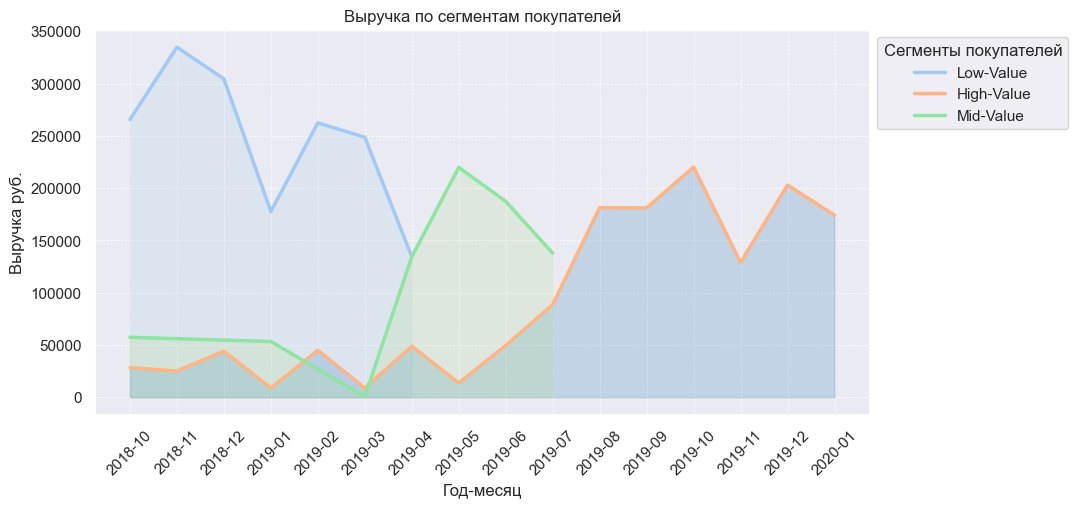

In [61]:
plt.figure(figsize=(10,5))
color = sns.color_palette('pastel', n_colors=len(df['value_segment'].unique()))
for i, value in enumerate(df['value_segment'].unique()):
    data = df.query('value_segment==@value').groupby('year_month').agg(revenue = ('revenue','sum'))
    sns.lineplot(data=data, x='year_month', y='revenue', color=color[i], legend='auto', label=value, linewidth=2.5)
    plt.fill_between(data.index, data['revenue'], alpha=0.2, color=colors[i])

# Установка заголовка и меток осей
plt.title('Выручка по сегментам покупателей')
plt.xlabel('Год-месяц')
plt.ylabel('Выручка руб.')

# Поворот меток на оси x
plt.xticks(rotation=45)

# Добавление сетки
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Добавление легенды и вынесение её за пределы графика справа
plt.legend(title='Сегменты покупателей', bbox_to_anchor=(1, 1), loc='upper left')

# Отображение графика
plt.show()


### Анализ покупателей: выводы

- наши покупатели разбиты на следующие категории

    - Low-Value	1306 клиентов,	1370 заказов
    - Mid-Value	568 клиентов,	647 заказов
    - High-Value	1182 клиентов,	1507 заказов

Несмотря на то, что данных для полноценного анализа маловато, из графика мы уже можем сделать вывод, что 2 группы покупателей в середине периода перестали совершать покупки: low-value в апреле 2019, mid-value в июле. Более того, покупатели из группы low-value до апреля 2019 лидировали в покупках. Возможно, поменялась ценовая политика или скидочные карты закончились или мы недостаточно внимания уделяли покупателям из low & mid категорий, надо обсуждать с коллегами. Желательно вернуть покупателей хотя бы из mid-value с помощью рассылок, спец. предложений и пр. акций.




## Формулировка гипотез и их проверка

### Гипотеза №1

Давайте проверим гипотезу о том, что за период продаж изменилось значение среднего чека (сумма заказа / количество позиций в заказе)

**Н0:** средний чек заказов за периоды 2018-10-2019-01 и 2019-10-2020-01 **равны**<br>
**Н1:** средние чеки **отличаются**

In [62]:
# подготовим таблицы со значениями средних чеков за указанные периоды

set1 = df.query('year_month.isin(["2018-10","2018-11","2018-12","2019-01"])').groupby('order_id').agg(sum=('revenue','sum'), qty=('quantity','sum')).reset_index()
set1['avg']=set1['sum'] / set1['qty']

set2 = df.query('year_month.isin(["2019-10","2019-11","2019-12","2020-01"])').groupby('order_id').agg(sum=('revenue','sum'), qty=('quantity','sum')).reset_index()
set2['avg']=set2['sum'] / set2['qty']


display(set1)
display(set2)

,order_id,sum,qty,avg
0,13547,684.0,3,228.000000
1,14480,359.0,3,119.666667
2,14481,600.0,4,150.000000
3,14482,376.0,2,188.000000
4,14485,676.0,4,169.000000
...,...,...,...,...
886,70036,974.0,1,974.000000
887,70041,1424.0,2,712.000000
888,70043,74.0,1,74.000000
889,70045,1424.0,1,1424.000000


,order_id,sum,qty,avg
0,14939,646.0,4,161.500000
1,14940,135.0,1,135.000000
2,14941,1699.0,12,141.583333
3,14942,270.0,2,135.000000
4,14943,555.0,4,138.750000
...,...,...,...,...
933,112722,450.0,1,450.000000
934,112732,90.0,1,90.000000
935,112767,38.0,1,38.000000
936,112779,172.0,1,172.000000


- посмотрим на распределение значений средних чеков и на дисперсию: для проведения t-теста на равенство средних 2х генеральных совокупностей.



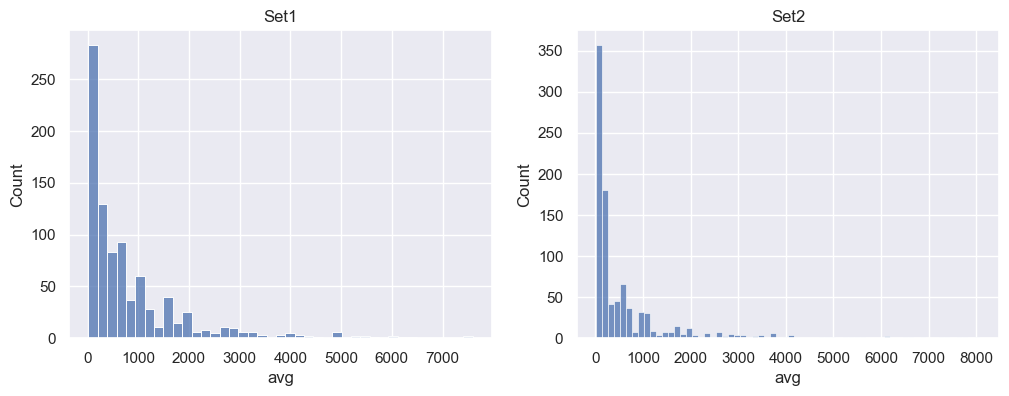

Дисперсия 1: 1169134.975675601
Дисперсия 2: 1340212.546789521


In [63]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(data=set1, x='avg', ax=ax[0])
sns.histplot(data=set2, x='avg', ax=ax[1])
ax[0].set_title('Set1')
ax[1].set_title('Set2')
plt.show()

print('Дисперсия 1: {}\nДисперсия 2: {}'.format(set1['avg'].var(),set2['avg'].var()))

In [64]:
alpha = 0.05 # уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу

results = stats.ttest_ind(set1['avg'], set2['avg'], alternative='two-sided', equal_var=False) # проверяем на равенство средних и указываем на различие в дисперсии выборок

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: средние значения не равны')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.0010807959447485956
Отвергаем нулевую гипотезу: средние значения не равны


- итог - **есть статистически значимые различия средних значений средних чеков, гипотеза о равенстве средних чеков заказов 2х периодов отклоняется**.

Посмотрим теперь, можно ли утверждать, что средние чеки стали **меньше?**.

H0: средние чеки периодов равны<br>
Н1: средние чеки периода 1 **больше**.


In [65]:
# используем в нашей проверке генеральных совокупностей условие

alpha = 0.05 # уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу

results = stats.ttest_ind(set1['avg'], set2['avg'], alternative='greater', equal_var=False) # проверяем на равенство средних и указываем на различие в дисперсии выборок

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.0005403979723742978
Отвергаем нулевую гипотезу


- вывод - средние чеки заказов во втором периоде (2019-10 - 2020-01) действительно **стали меньше**, чем в первом (2018-10-2019-01). Другими словами, покупатели стали выбирать более дешевые товары, или произошло общее снижение цен.

### Гипотеза №2

Посмотрим, изменилось ли среднее количество заказов, которое делают наши клиенты.<br>


Сначала проверим на **равенство**<br>
H0: среднее количество заказов равно<br>
Н1: среднее количество заказов не равно<br>

In [66]:
# подготовим данные для сравнения по периодам

set3 = (
    df.query('year_month.isin(["2018-10","2018-11","2018-12","2019-01"])')
    .groupby('customer_id')
    .agg(order_count=('order_id','nunique'))
    .sort_values(by='order_count', ascending=False)
    .reset_index()
)

set4 = (
    df.query('year_month.isin(["2019-10","2019-11","2019-12","2020-01"])')
    .groupby('customer_id')
    .agg(order_count=('order_id','nunique'))
    .sort_values(by='order_count', ascending=False)
    .reset_index()
)
display(set3)
display(set4)

,customer_id,order_count
0,c971fb21-d54c-4134-938f-16b62ee86d3b,90
1,4d93d3f6-8b24-403b-a74b-f5173e40d7db,35
2,552e17df-ba16-4e66-84fb-55a5557a6bea,3
3,f163e581-59ba-4022-99db-e0973c7497c0,3
4,5d566073-92e8-41d1-a2e6-d301ee5ab6d8,3
...,...,...
735,61eb5dd8-2029-40eb-bc5e-038cae9f9d3e,1
736,62956806-02d5-41c7-ac4b-18a8883a0884,1
737,631c5729-d163-4270-8956-4d9832085d0e,1
738,6362dd50-4d12-41a4-8534-44cb67c92ee3,1


,customer_id,order_count
0,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,17
1,0adba506-249c-40b5-839d-a59d7a275cd7,3
2,2a8b22dd-1929-4c10-bbeb-b57953584d9d,2
3,cdd17932-623e-415f-a577-3b31312fd0e2,2
4,7abce1cc-bc8c-4362-b61a-0cbb4822ed29,2
...,...,...
906,56710968-02ea-46b7-9638-0ad9fa8544d0,1
907,5699cf84-adae-4465-9831-ead94c9ecee6,1
908,57659817-b1c5-4eea-8d0a-a8bdc1770022,1
909,579034b8-ab03-4077-b8c7-7a5e0289e412,1


- посмотрим на распределение значений количества заказов и на дисперсию: для проведения t-теста на равенство средних 2х генеральных совокупностей.



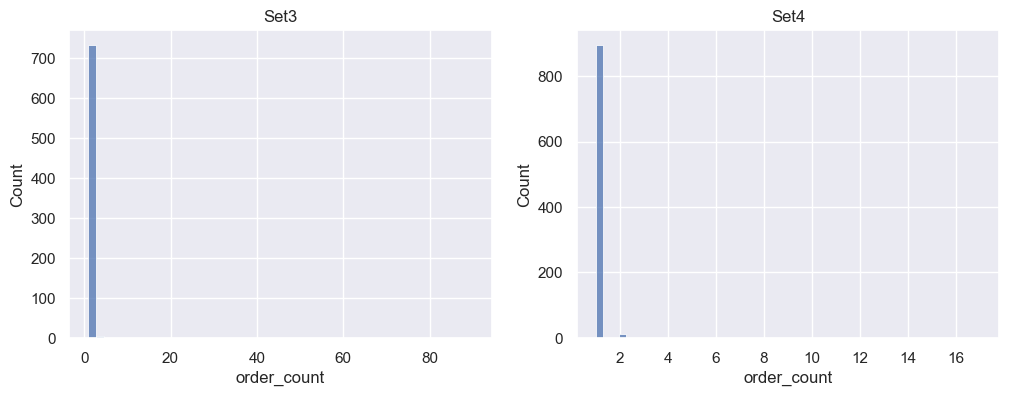

Дисперсия 1: 12.295351643931454
Дисперсия 2: 0.2988407859977626


In [67]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(data=set3, x='order_count', ax=ax[0], bins=50)
sns.histplot(data=set4, x='order_count', ax=ax[1], bins=50)
ax[0].set_title('Set3')
ax[1].set_title('Set4')
plt.show()

print('Дисперсия 1: {}\nДисперсия 2: {}'.format(set3['order_count'].var(),set4['order_count'].var()))

In [68]:
alpha = 0.05 # уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу

results = stats.ttest_ind(set3['order_count'], set4['order_count'], alternative='two-sided', equal_var=False) # проверяем на равенство средних и указываем на различие в дисперсии выборок

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: средние значения не равны')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.16833147909873386
Не получилось отвергнуть нулевую гипотезу


- выходит, у нас **нет оснований отвергать нулевую гипотезу о равенстве среднего количества заказов** на клиента в первом и вором периодах. Другими словами, среднее количество заказов, которое делают клиенты **не изменилось**.


### Формулировка гипотез и их проверка: выводы

Мы проверили несколько гипотез, касающихся продаж двух сопоставимых четырехмесячных периодов - 2018-10 - 2019-01 и 2019-10 - 2020-01: 
1) средние чеки заказов стали меньше. Это говорит о том, что либо цены стали меньше, либо покупатели стали выбирать более дешевые позиции
2) несмотря на уменьшение средних чеков и общее падение продаж, среднее количество заказов, совершаемых одним пользователем не изменилось. Это говорит о том, что, несмотря на то, что популярность магазина осталась на том же уровне, мы не обзавелись лояльными покупателями. 

## Итоговые выводы исследования и рекомендации

Итак, в нашем распоряжении были данные продаж интернет-магазина товаров для дома и быта за период 15 месяцев: 2018-10 - 2020-01. Нам нужно было провести анализ товарного ассортимента и потребителей.

Какие основные выводы и рекомендации мы можем сделать?
1) В нашем ассортименте **2342** товарных наименований, из которых **27%** занимает категория **"Растения"**, хотя по продажам лидируют **"Хозтовары" и "Тележки и сумки"** (суммарно **43% всех продаж**), количество наименований которых в ассортименте сильно ниже - 15.5% и 4.7% соответственно.<br><br>
`Рекомендация`: расширить ассортимент лидирующих категорий и сократить ассортимент "Растений", пик сезона продаж которых приходится на **апрель-май**. В остальные месяцы можно их меньше держать на складе и меньше тратить ресурсов на уход за ними.<br><br>
2) В целом, продажи больше в будние дни, чем по выходным. Наши ключевые категории -  Хозтовары лучше всего продаются **во вторник**, за тележками идут **в пятницу**.<br><br>
`Рекомендация`: использовать для увеличения продаж указанных категорий с помощью маркетинга рассылки, приуроченные к определенным дням недели или спец. предложения на главной странице магазина.<br><br>
3) 95% клиентов сделали всего **1-3 заказа** и в 95% заказов всего **1-3 позиции**..<br><br>
`Рекомендация:` следует предпринять меры для увеличения количества позиций в заказе и числа повторных заказов.
 Например, для увеличения количества позиций можно предложить рубрику "Вместе с этим товаром часто покупают... " в карточках товара. Для увеличения числа повторных заказов надо работать с удержанием и вовлечением пользователей - карты покупателя, система скидок, рассылки. <br><br>
4)  Мы провели сегментацию наших продуктов на АВС категории по продажам:
    - в класс А по выручке попали 629 продуктов, что составило 27% от их общего количества
    - В - 365 продуктов
    - С - 1348 продуктов

    `Рекомендация:`Следует пересмотреть набор товаров из группы А (есть признаки проблем с поддержанием наличия, либо с плохим ценообразованием на ключевые товары) и сделать маркетинговый акцент на ТОП-100 из них.<br>
    Успешная декабрьская акция с тележками - масштабировать и повторить. 
5) Наши покупатели разбиты на следующие категории

    - Low-Value	1306 клиентов,	1370 заказов
    - Mid-Value	568 клиентов,	647 заказов
    - High-Value	1182 клиентов,	1507 заказов

    2 группы покупателей в середине периода перестали совершать покупки: low-value в апреле 2019, mid-value в июле.<br><br>
    `Рекомендация:` Желательно вернуть покупателей из **mid-value** с помощью рассылок, спец. предложений и прочих акций и вообще, пересмотреть систему удержания и повышения лояльности.<br><br>
6) Напоследок нами были проверены 2 гипотезы - **изменился ли средний чек заказа** и **изменилось ли среднее количество заказов на клиента** в сопоставимые 4 месяца продаж (октябрь-январь).<br><br>
    `Выводы:` за год средний чек заказа (сумма заказа / единиц товара в нем) действительно **уменьшился** - либо общие цены снизились, либо стали покупать более дешевые товары. Среднее количество заказов на клиента **осталось на прежнем уровне** - мы не обзавелись лояльными покупателями.

Результаты данного исследования будут представлены в виде презентации, а также в виде дашборда Tableau по ссылкам ниже:

[Cсылка на презентацию](https://disk.yandex.ru/i/2uHwHeEYJWG9vQ)<br>
[Cсылка на дашборд Tableau](https://public.tableau.com/shared/G5QHYCDTC?:display_count=n&:origin=viz_share_link)

In [69]:
    # Сохраняем финальный DataFrame в CSV файл
df.to_csv('ecom_dataset_final.csv', index=False)